In [1]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import missingno as msno
import geopandas as gpd
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
import warnings
from datetime import timedelta
from utils import *
import os
import session_info
from preprocessing import preprocessing

pd.set_option('display.max_columns', None)
%config InlineBackend.figure_format='retina'
warnings.filterwarnings('ignore')

In [2]:
session_info.show()

In [3]:
folder_name = '../Inputs/'
file_name = 'dataset_SCL.csv'

## Answers of challenge

### 1. How is the data distributed? Did you find any noteworthy insight to share? What can you conclude about this?

Reading Data

In [5]:
prepro_ans = preprocessing(folder_name + file_name)
df = prepro_ans.read_data()

In [6]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68206 entries, 0 to 68205
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Fecha-I    68206 non-null  object
 1   Vlo-I      68206 non-null  object
 2   Ori-I      68206 non-null  object
 3   Des-I      68206 non-null  object
 4   Emp-I      68206 non-null  object
 5   Fecha-O    68206 non-null  object
 6   Vlo-O      68205 non-null  object
 7   Ori-O      68206 non-null  object
 8   Des-O      68206 non-null  object
 9   Emp-O      68206 non-null  object
 10  DIA        68206 non-null  int64 
 11  MES        68206 non-null  int64 
 12  AÑO        68206 non-null  int64 
 13  DIANOM     68206 non-null  object
 14  TIPOVUELO  68206 non-null  object
 15  OPERA      68206 non-null  object
 16  SIGLAORI   68206 non-null  object
 17  SIGLADES   68206 non-null  object
dtypes: int64(3), object(15)
memory usage: 9.4+ MB


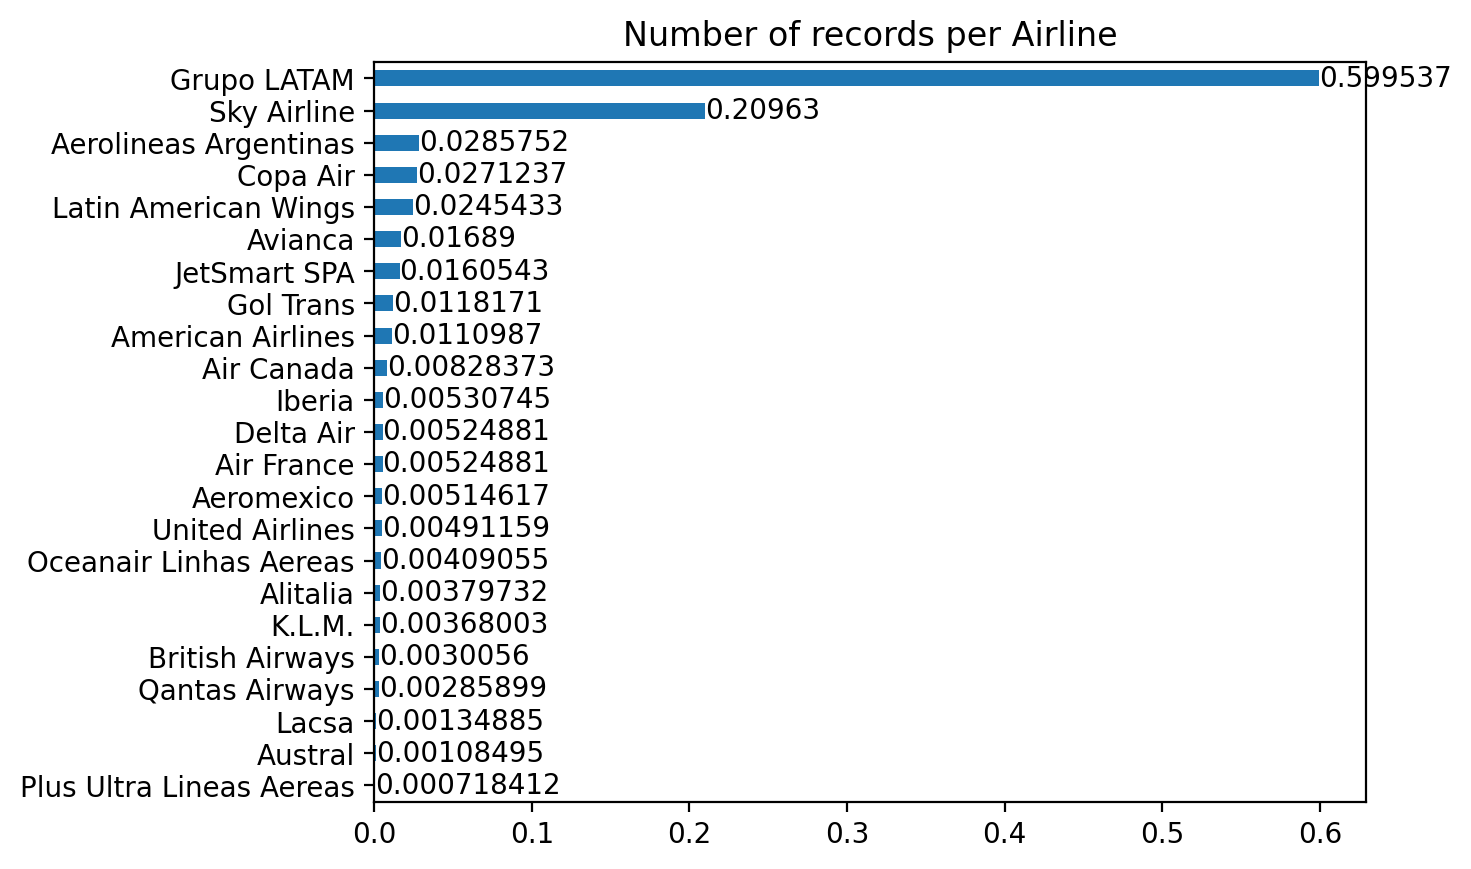

In [7]:
ax = df.OPERA.value_counts(ascending=True, normalize=True).plot.barh()
ax.set_title('Number of records per Airline')
ax.bar_label(ax.containers[0]);

El 80% de los vuelos son operados por el Grupo LATAM y Sky airlines

In [13]:
df.groupby('TIPOVUELO').size()

TIPOVUELO
I    31240
N    36966
dtype: int64

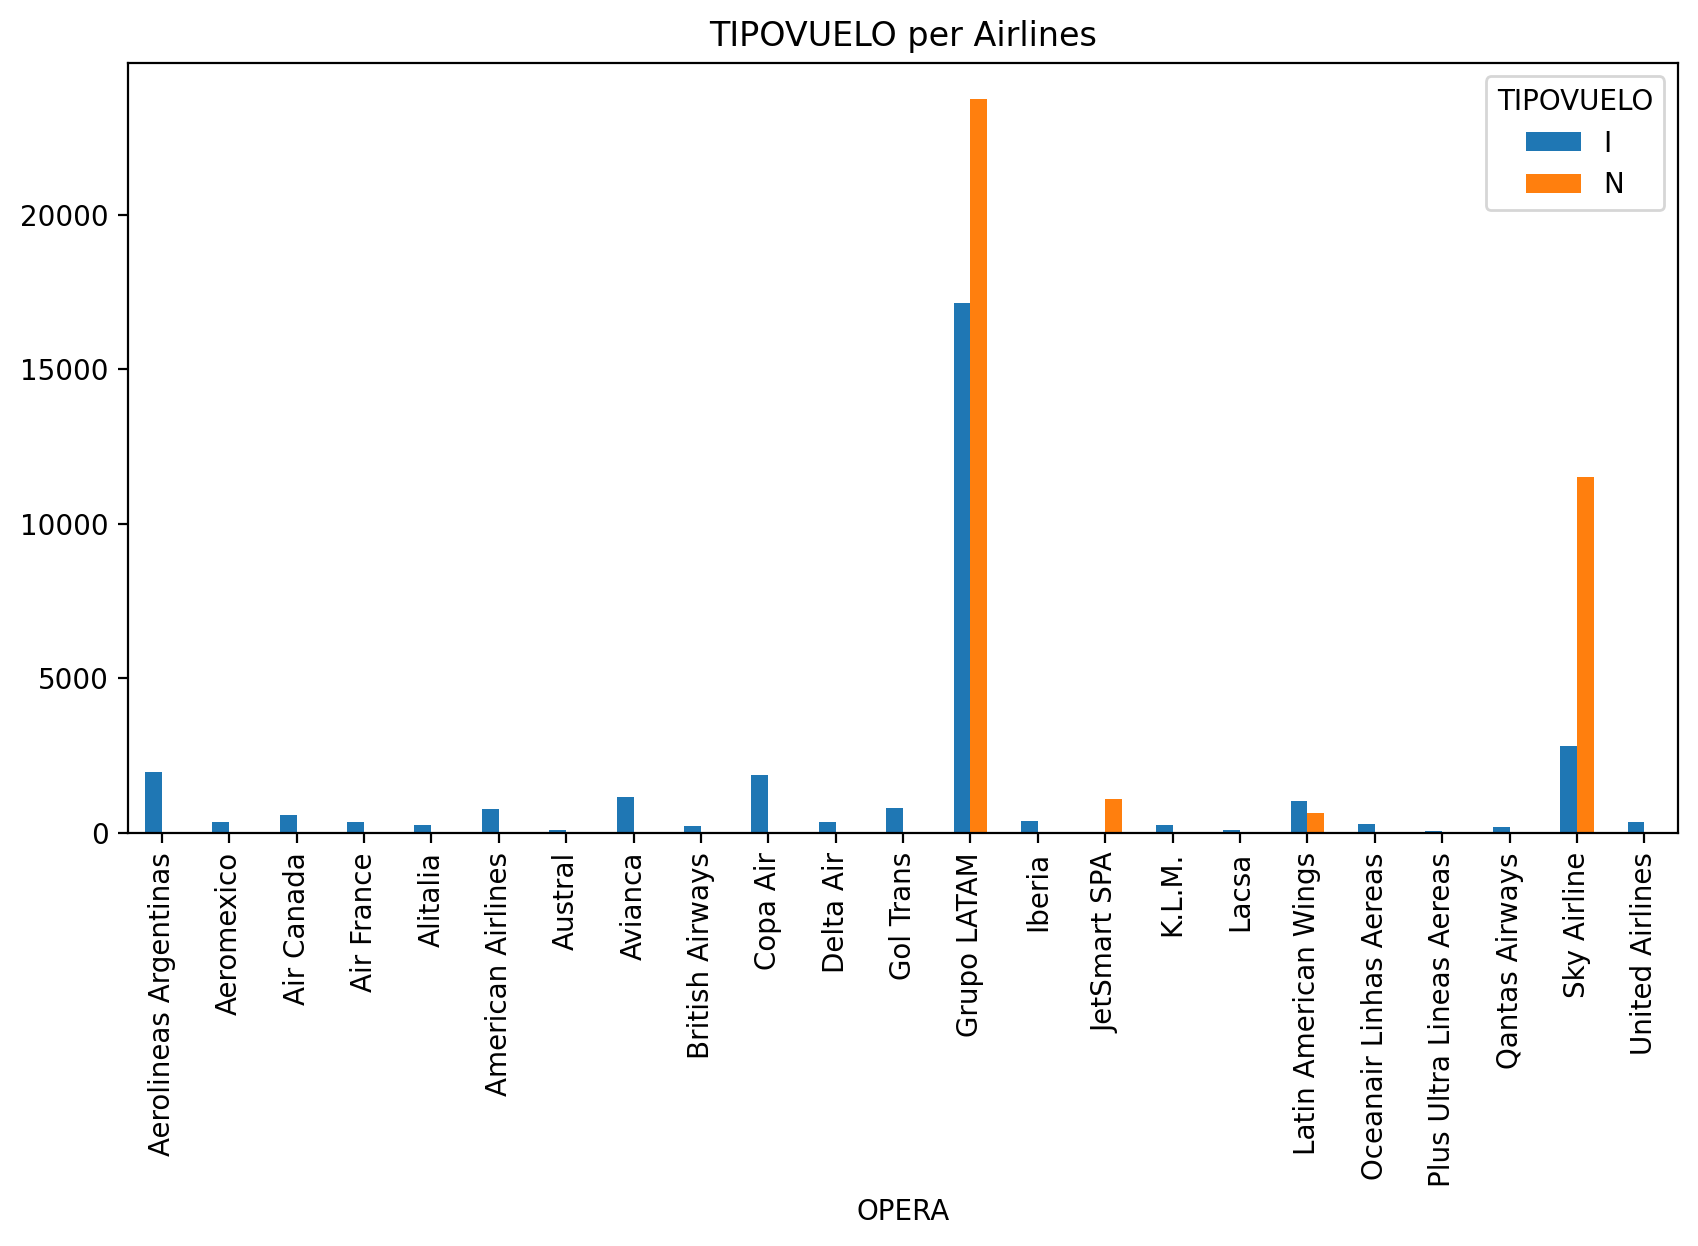

In [26]:
ax = df.groupby(['OPERA','TIPOVUELO']).size().unstack().plot(kind='bar', stacked=False, figsize=(10,5)).set_title('TIPOVUELO per Airlines');

Validate format of dates

In [32]:
df = prepro_ans.validate(df, 'Fecha-I')
df = prepro_ans.validate(df, 'Fecha-O')

The date format is correct
The date format is correct


In [10]:
df.groupby(["Ori-I",'SIGLAORI']).size()

Ori-I  SIGLAORI
SCEL   Santiago    68206
dtype: int64

The only origin of flights is Chile, so we can think that weather data its a good option for add to data.

Getting weather data from meteostat at airport of Santiago

In [44]:
# import libraries
from meteostat import Point, Daily,Hourly
from datetime import datetime

In [45]:
# Set time period
start = datetime(2017, 1, 1)
end = datetime(2017, 12, 31)

# Create Point for airport of Santiago
santiago = Point(-33.40120502046634, -70.79999384307274, 520) # that cordenate correspond to the airport of Santiago, got it from google maps

# Get data for 2017
data = Hourly(santiago, start, end)
data = data.fetch()

# we can get the precipitation data from Daily data but not from Hourly data
data_daily = Daily(santiago, start, end)
data_daily = data_daily.fetch()

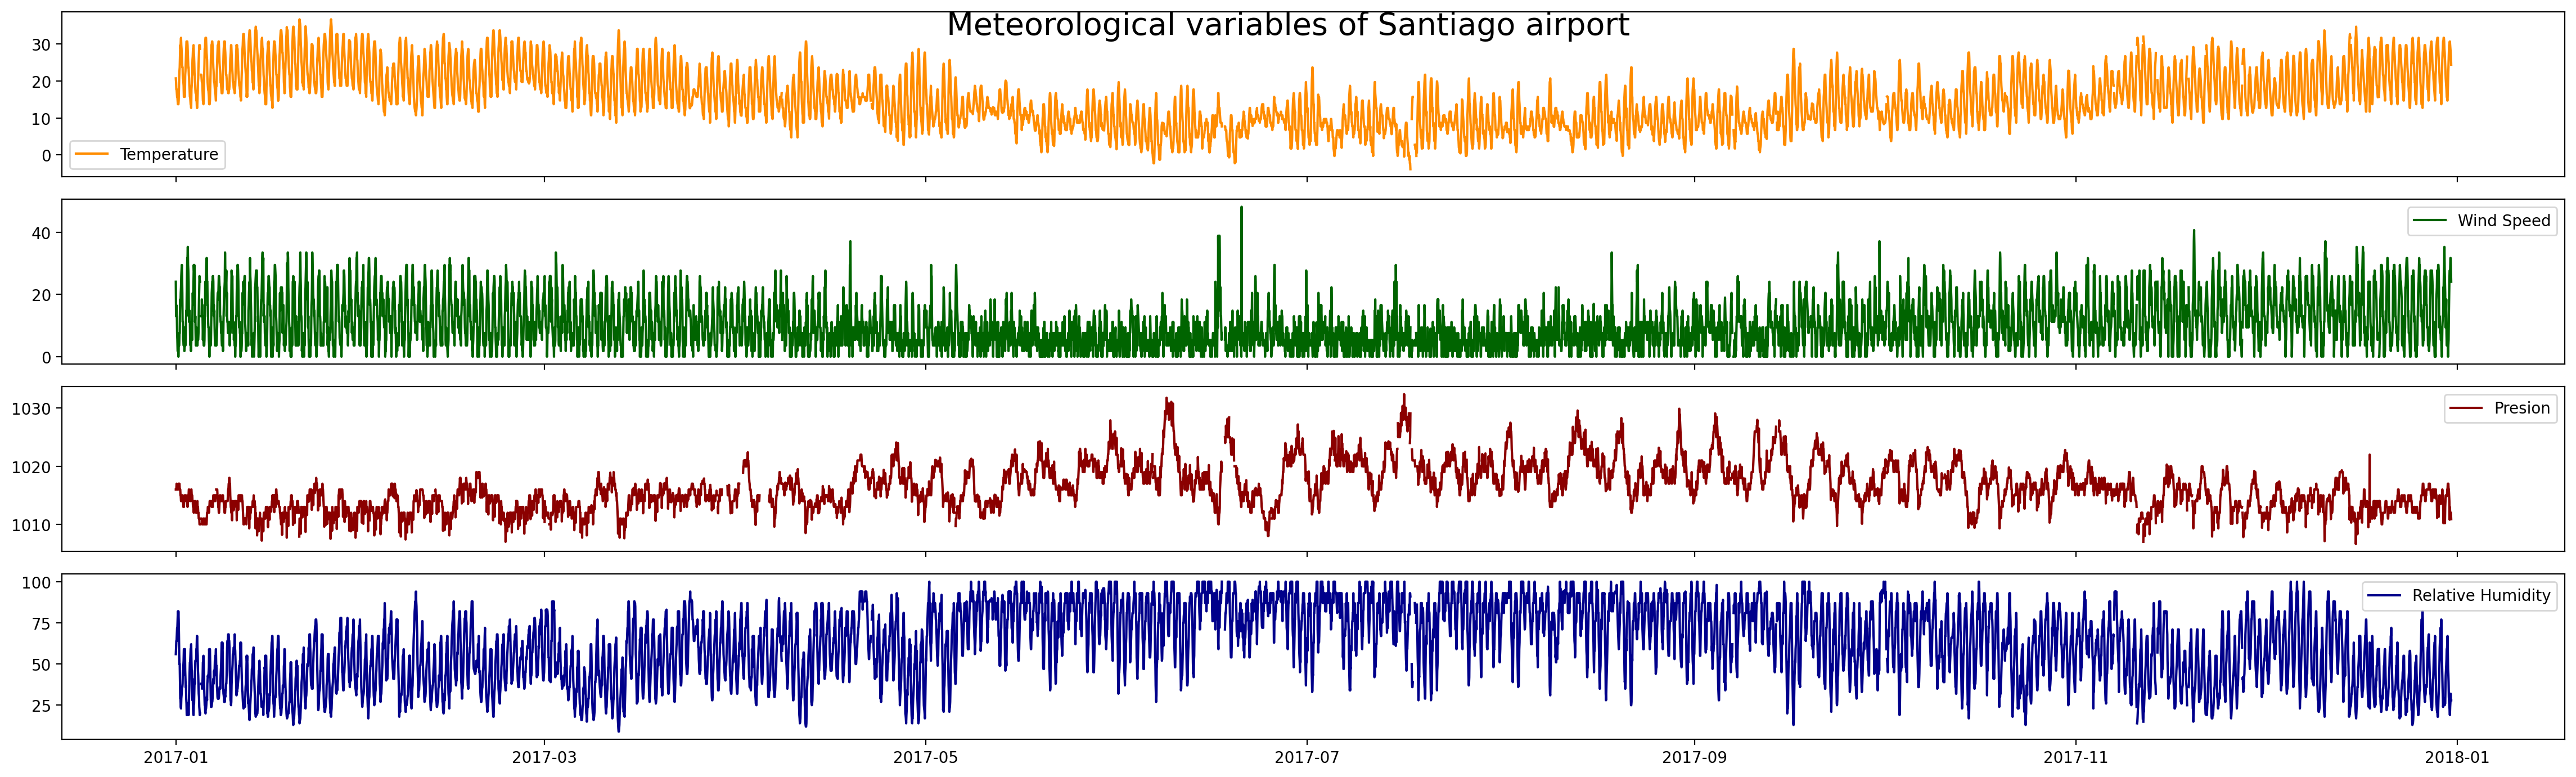

In [34]:
fig, axes = plt.subplots(4,1,figsize=(23, 7), sharex=True)
axes[0].plot(data.index,data.temp, label='Temperature', c = 'darkorange')
axes[1].plot(data.index,data.wspd, label='Wind Speed', c = 'darkgreen')
axes[2].plot(data.index,data.pres, label='Presion', c='darkred')
axes[3].plot(data.index,data.rhum, label='Relative Humidity' , c= 'darkblue')

axes[0].legend()
axes[1].legend()
axes[2].legend()
axes[3].legend()
fig.tight_layout()
fig.suptitle('Meteorological variables of Santiago airport', fontsize=20);

Time series analysis could be a good aproach to treat this information, forecasting, etc... For now add this feature to df it is good part for start. 

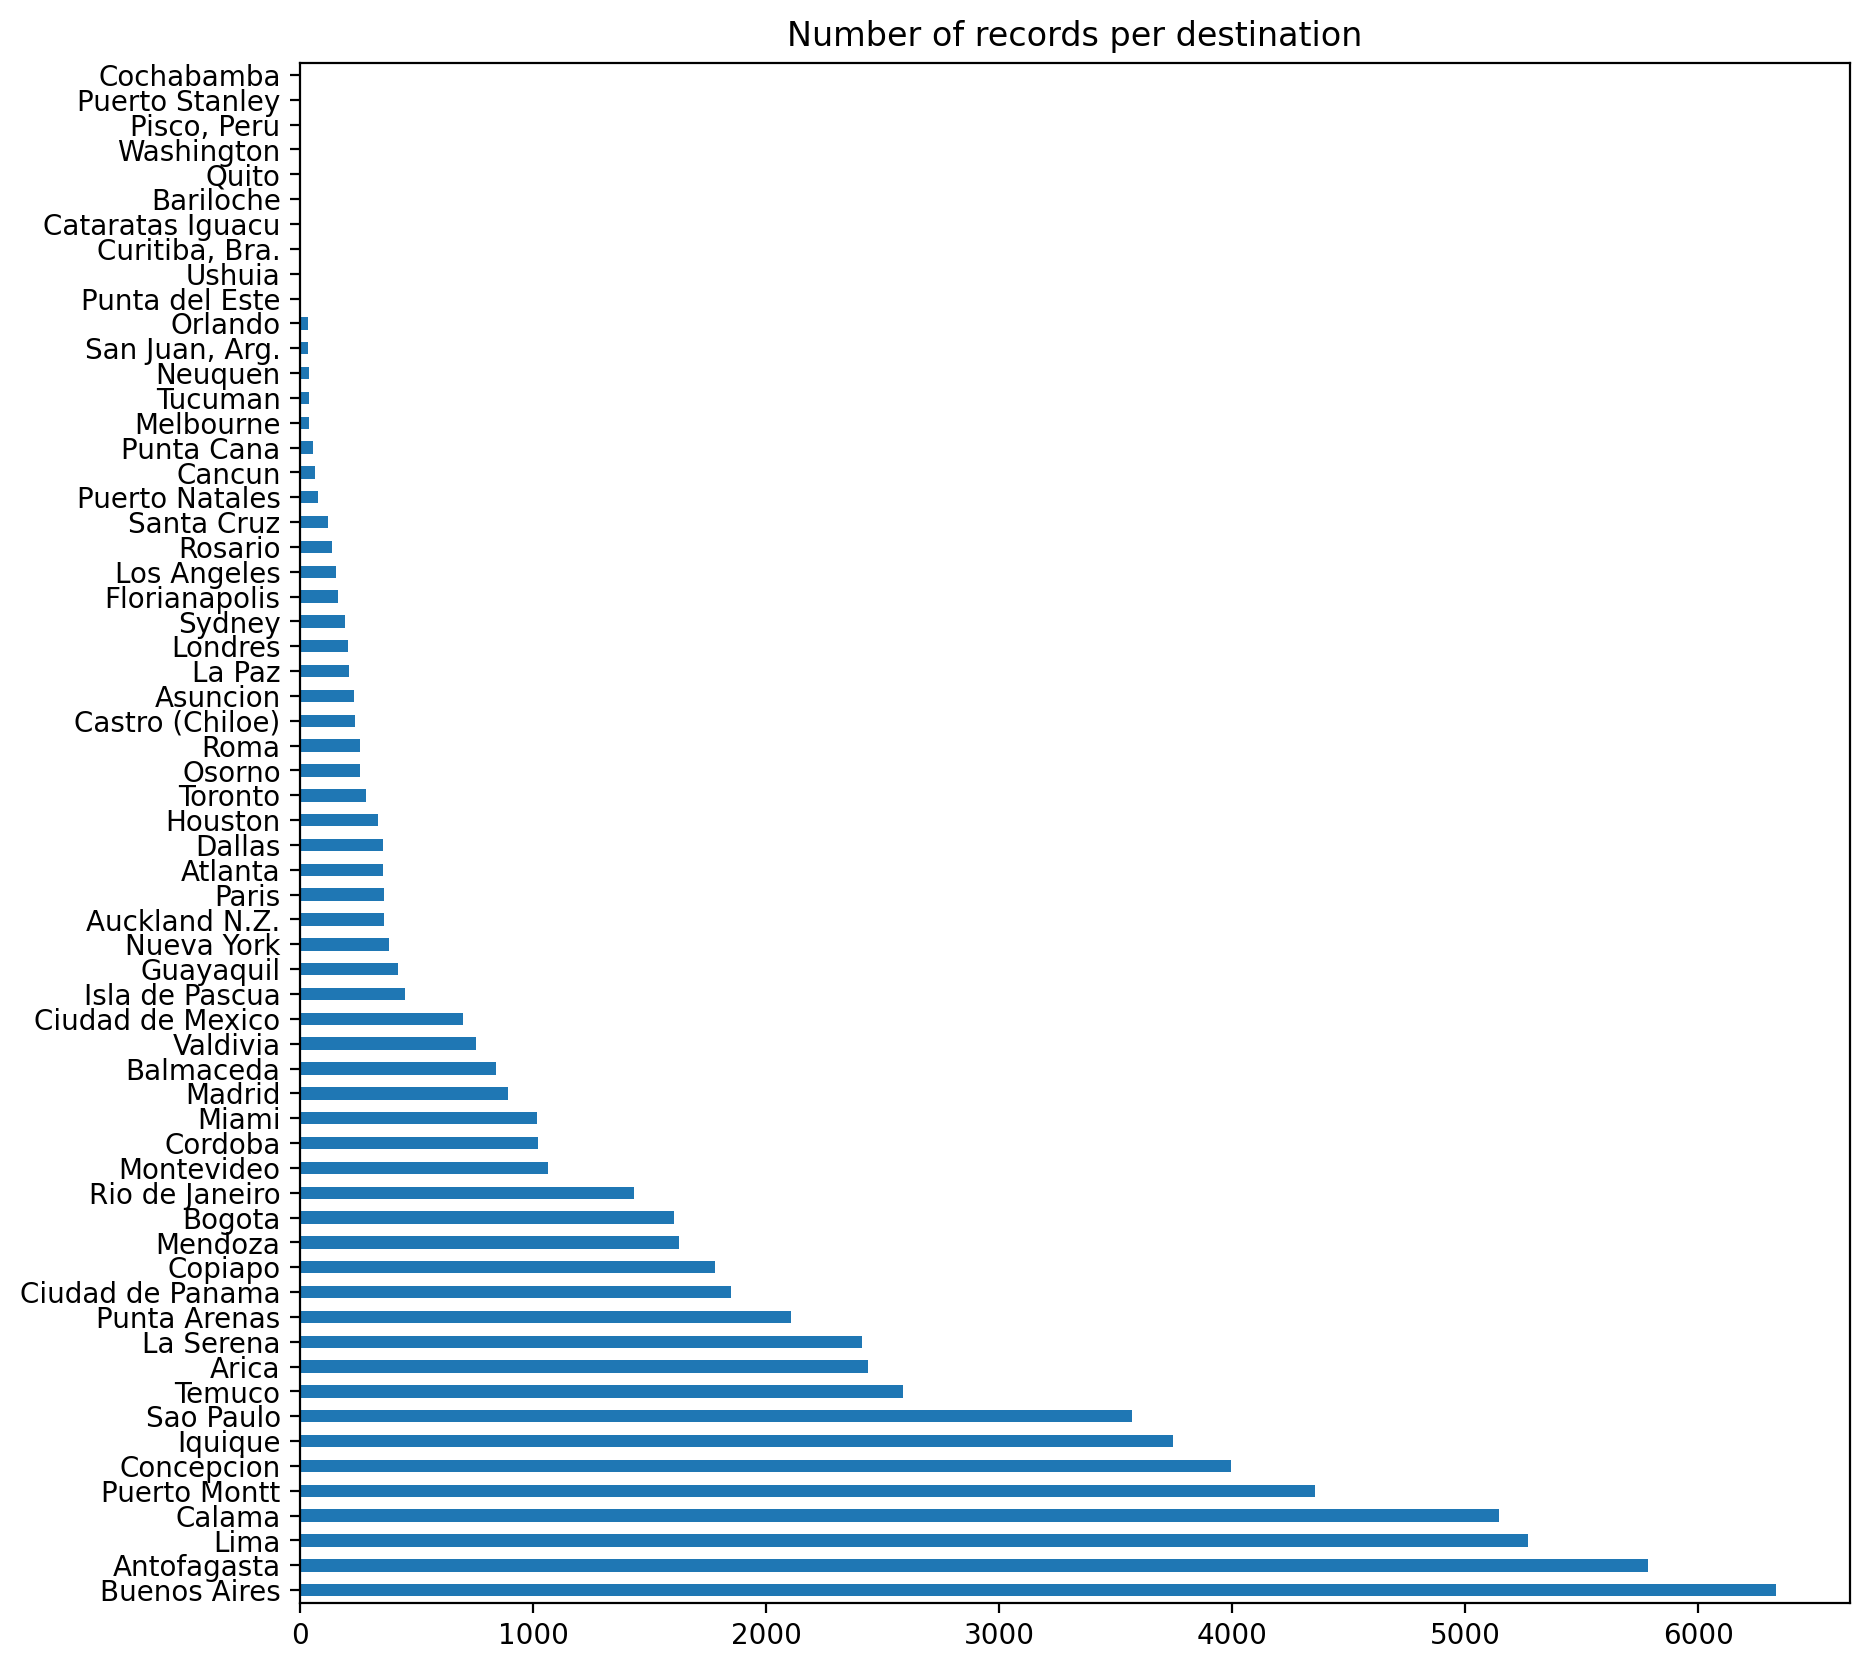

In [38]:
df.SIGLADES.value_counts().plot.barh(figsize=(10, 10), title='Number of records per destination');

In [39]:
df.groupby('OPERA')['Fecha-I'].agg([min,max])

min                 max
OPERA                                                           
Aerolineas Argentinas    2017-01-01 10:35:00 2017-12-31 10:50:00
Aeromexico               2017-01-01 00:15:00 2017-12-31 23:45:00
Air Canada               2017-01-01 13:35:00 2017-12-31 21:10:00
Air France               2017-01-01 14:25:00 2017-12-31 14:15:00
Alitalia                 2017-01-01 12:45:00 2017-12-30 12:45:00
American Airlines        2017-01-01 22:00:00 2017-12-31 23:55:00
Austral                  2017-01-07 22:30:00 2017-12-31 14:20:00
Avianca                  2017-01-01 01:33:00 2017-12-31 16:16:00
British Airways          2017-01-04 18:45:00 2017-12-31 17:30:00
Copa Air                 2017-01-01 01:23:00 2017-12-31 12:05:00
Delta Air                2017-01-01 21:50:00 2017-12-31 21:50:00
Gol Trans                2017-01-01 02:05:00 2017-12-31 14:30:00
Grupo LATAM              2017-01-01 01:15:00 2017-12-31 23:55:00
Iberia                   2017-01-01 13:40:00 2017-12-31 13:35:00
JetSmart SPA             2017-07-24 09:30:00 2017-12-31 20:11:00
K.L.M.                   2017-01-02 12:45:00 2017-12-31 12:45:00
Lacsa                    2017-09-01 07:14:00 2017-12-31 06:55:00
Latin American Wings     2017-01-01 11:00:00 2017-12-31 22:00:00
Oceanair Linhas Aereas   2017-08-06 13:50:00 2017-12-31 13:40:00
Plus Ultra Lineas Aereas 2017-07-03 20:30:00 2017-12-27 22:30:00
Qantas Airways           2017-01-01 13:35:00 2017-12-31 13:35:00
Sky Airline              2017-01-01 05:50:00 2017-12-31 22:50:00
United Airlines          2017-01-01 22:40:00 2017-12-31 23:30:00

In [46]:
df.groupby(["Emp-I",'Emp-O']).size() # its possible that the flight is operated by another airline different from scheduled airline

Emp-I  Emp-O
AAL    AAL        757
ACA    ACA        565
AFR    AFR        358
AMX    AMX        351
ARG    ARG       1944
       AUT          5
AUT    ARG          2
       AUT         72
AVA    AVA        885
       LRC        265
       TPU          2
AZA    AZA        259
BAW    BAW        205
CMP    CMP       1850
DAL    DAL        358
DSM    DSM          2
GLO    GLO        806
IBE    IBE        362
JAT    JAT       1095
JMR    JMR        100
KLM    KLM        251
LAN    DSM        491
       LAN      20988
       LNE        373
       LPE       1210
       LXP      14549
LAP    LAP        216
LAW    48O         10
       56R         17
       JMR       1547
LNE    LNE          1
LPE    LPE          4
LRC    LRC         92
LXP    LXP          9
ONE    ONE        279
PUE    PUE         49
QFU    QFA        195
SKU    SKU      14298
TAM    LAP          3
       TAM       3046
UAL    UAL        335
dtype: int64

In [61]:
df.loc[~(df['Des-I'] == df['Des-O'])] 
# its possible that Destination scheduled is different from Destination operated (maybe because of a delay). weird... but possible (?)

Fecha-I Vlo-I Ori-I Des-I Emp-I             Fecha-O   Vlo-O  \
1397  2017-01-17 19:20:00    25  SCEL  SCTE   SKU 2017-01-17 19:46:00      25   
7290  2017-02-15 06:25:00    11  SCEL  SCTE   SKU 2017-02-15 06:25:00      11   
7520  2017-02-27 06:40:00    71  SCEL  SCIE   SKU 2017-02-27 09:07:00      71   
8456  2017-02-15 06:10:00    57  SCEL  SCTE   LAN 2017-02-15 06:12:00      57   
12787 2017-03-18 06:25:00    11  SCEL  SCTE   SKU 2017-03-18 06:29:00      11   
12823 2017-03-22 12:50:00    17  SCEL  SCBA   SKU 2017-03-22 12:48:00      17   
16169 2017-03-13 23:20:00   532  SCEL  KJFK   LAN 2017-03-14 01:35:00    1346   
16937 2017-03-22 17:00:00  1446  SCEL  SEGU   LAN 2017-03-22 17:11:00    1361   
18293 2017-04-14 18:40:00    25  SCEL  SCTE   SKU 2017-04-14 18:48:00      25   
20444 2017-04-14 22:00:00   289  SCEL  SCTE   LAN 2017-04-14 22:01:00     289   
24569 2017-05-13 18:25:00   136  SCEL  SCFA   LAN 2017-05-13 18:24:00     136   
25419 2017-05-09 08:30:00   271  SCEL  SCBA   LAN 2017-05-09 08:31:00     271   
25422 2017-05-12 08:25:00   271  SCEL  SCBA   LAN 2017-05-12 08:36:00     271   
25492 2017-05-12 09:15:00   279  SCEL  SCBA   LAN 2017-05-12 09:26:00     279   
33166 2017-07-04 01:25:00  9261  SCEL  SBGR   GLO 2017-07-04 01:19:00    9261   
37162 2017-07-26 08:45:00   455  SCEL  SABE   LAN 2017-07-26 09:45:00    1155   
38094 2017-07-03 07:55:00  7811  SCEL  SABE   LAN 2017-07-03 08:03:00    1111   
38135 2017-07-17 16:00:00  7813  SCEL  SABE   LAN 2017-07-17 16:41:00    1113   
38136 2017-07-18 16:00:00  7813  SCEL  SABE   LAN 2017-07-18 16:31:00    1113   
39265 2017-08-29 21:55:00   846  SCEL  KIAH   UAL 2017-08-29 21:55:00    2763   
42112 2017-08-07 11:00:00   293  SCEL  SCCI   LAN 2017-08-07 11:07:00     293   
55144 2017-10-06 00:55:00  1260  SCEL  SEQU   LAN 2017-10-06 02:15:00    1260   
61463 2017-11-06 06:00:00  1031  SCEL  SCIE   LAW 2017-11-06 08:01:00    1031   
62651 2017-12-10 13:35:00    28  SCEL  YSSY   QFU 2017-12-10 13:40:00      28   
67599 2017-12-01 11:20:00  7811  SCEL  SAEZ   LAN 2017-12-01 11:22:00  7811.0   
67600 2017-12-02 11:15:00  7811  SCEL  SAEZ   LAN 2017-12-02 11:21:00  7811.0   
67601 2017-12-03 11:20:00  7811  SCEL  SAEZ   LAN 2017-12-03 11:30:00  7811.0   
67697 2017-12-16 02:45:00  1261  SCEL  SARI   LAN 2017-12-16 02:43:00  1261.0   

      Ori-O Des-O Emp-O  DIA  MES   AÑO     DIANOM TIPOVUELO  \
1397   SCEL  SCQP   SKU   17    1  2017     Martes         N   
7290   SCEL  SCQP   SKU   15    2  2017  Miercoles         N   
7520   SCEL  SCQP   SKU   27    2  2017      Lunes         N   
8456   SCEL  SCQP   LAN   15    2  2017  Miercoles         N   
12787  SCEL  SCQP   SKU   18    3  2017     Sabado         N   
12823  SCEL  SCTE   SKU   22    3  2017  Miercoles         N   
16169  SCEL  KMIA   LAN   14    3  2017     Martes         I   
16937  SCEL  SABE   LAN   22    3  2017  Miercoles         I   
18293  SCEL  SCQP   SKU   14    4  2017    Viernes         N   
20444  SCEL  SCCI   LXP   14    4  2017    Viernes         N   
24569  SCEL  SCCF   LAN   13    5  2017     Sabado         N   
25419  SCEL  SCTE   LXP    9    5  2017     Martes         N   
25422  SCEL  SCTE   LXP   12    5  2017    Viernes         N   
25492  SCEL  SCTE   LXP   12    5  2017    Viernes         N   
33166  SCEL  SBGL   GLO    4    7  2017     Martes         I   
37162  SCEL  SAEZ   LAN   26    7  2017  Miercoles         I   
38094  SCEL  SAEZ   LAN    3    7  2017      Lunes         I   
38135  SCEL  SAEZ   LAN   17    7  2017      Lunes         I   
38136  SCEL  SAEZ   LAN   18    7  2017     Martes         I   
39265  SCEL  KIAD   UAL   29    8  2017     Martes         I   
42112  SCEL  SCTE   LXP    7    8  2017      Lunes         N   
55144  SCEL  SEQM   LAN    6   10  2017    Viernes         I   
61463  SCEL  SCTE   JMR    6   11  2017      Lunes         N   
62651  SCEL  YMML   QFA   10   12  2017    Domingo         I   
67599  SCEL  SABE   DSM    1   12  2017    Viernes         I   
6760

In [88]:
pd.pivot_table(df.groupby(['OPERA',"MES"],as_index=False)['MES'].size(), index=['OPERA'], columns=['MES'])

size                                          \
MES                           1       2       3       4       5       6    
OPERA                                                                      
Aerolineas Argentinas      142.0   127.0   146.0   162.0   176.0   171.0   
Aeromexico                  32.0    25.0    30.0    30.0    32.0    28.0   
Air Canada                  59.0    48.0    47.0    45.0    39.0    48.0   
Air France                  31.0    28.0    30.0    30.0    31.0    29.0   
Alitalia                    23.0    20.0    21.0    20.0    22.0    22.0   
American Airlines           79.0    63.0    72.0    58.0    63.0    56.0   
Austral                      4.0     4.0     NaN     5.0     4.0     4.0   
Avianca                    122.0   100.0   108.0   109.0   112.0   105.0   
British Airways             16.0    16.0    17.0    17.0    18.0    17.0   
Copa Air                   176.0   158.0   139.0   143.0   149.0   149.0   
Delta Air                   31.0    28.0    31.0    30.0    31.0    30.0   
Gol Trans                   78.0    65.0    54.0    50.0    47.0    48.0   
Grupo LATAM               3858.0  3545.0  3388.0  3062.0  3191.0  2961.0   
Iberia                      31.0    28.0    30.0    30.0    31.0    29.0   
JetSmart SPA                 NaN     NaN     NaN     NaN     NaN     NaN   
K.L.M.                      21.0    20.0    22.0    21.0    18.0    21.0   
Lacsa                        NaN     NaN     NaN     NaN     NaN     NaN   
Latin American Wings        50.0    55.0    87.0   117.0   148.0   186.0   
Oceanair Linhas Aereas       NaN     NaN     NaN     NaN     NaN     NaN   
Plus Ultra Lineas Aereas     NaN     NaN     NaN     NaN     NaN     NaN   
Qantas Airways              20.0    16.0    18.0    17.0    13.0    12.0   
Sky Airline               1305.0  1188.0  1213.0  1046.0  1086.0  1040.0   
United Airlines             30.0    27.0    29.0    28.0    29.0    25.0   

                                                                          
MES                           7       8       9       10      11      12  
OPERA                                                                     
Aerolineas Argentinas      183.0   178.0   175.0   172.0   167.0   150.0  
Aeromexico                  28.0    31.0    29.0    28.0    29.0    29.0  
Air Canada                  54.0    52.0    46.0    44.0    40.0    43.0  
Air France                  29.0    31.0    29.0    29.0    30.0    31.0  
Alitalia                    22.0    22.0    22.0    22.0    21.0    22.0  
American Airlines           61.0    60.0    51.0    60.0    59.0    75.0  
Austral                      5.0     4.0     7.0    12.0    13.0    12.0  
Avianca                    118.0   111.0    71.0    36.0    89.0    71.0  
British Airways             17.0    18.0    17.0    18.0    16.0    18.0  
Copa Air                   181.0   167.0   146.0   154.0   144.0   144.0  
Delta Air                   29.0    31.0    29.0    30.0    28.0    30.0  
Gol Trans                   99.0    76.0    75.0    67.0    66.0    81.0  
Grupo LATAM               3631.0  3357.0  3240.0  3510.0  3575.0  3574.0  
Iberia                      31.0    31.0    29.0    31.0    30.0    31.0  
JetSmart SPA                12.0    90.0   154.0   263.0   252.0   324.0  
K.L.M.                      21.0    20.0    19.0    17.0    26.0    25.0  
Lacsa                        NaN     NaN    29.0    31.0     1.0    31.0  
Latin American Wings       201.0   172.0   169.0   139.0   166.0   184.0  
Oceanair Linhas Aereas       NaN    52.0    54.0    55.0    59.0    59.0  
Plus Ultra Lineas Aereas    13.0    12.0    12.0     4.0     3.0     5.0  
Qantas Airways              15.0    16.0    17.0    16.0    15.0    20.0  
Sky Airline               1211.0  1188.0  1164.0  1265.0  1225.0  1367.0  
United Airlines             31.0    25.0    26.0    29.0    26.0    30.0

In [89]:
pd.pivot_table(df.groupby(['OPERA',"MES"],as_index=False)['MES'].size(), index=['OPERA'], columns=['MES']).std(axis=1).sort_values(ascending=False)
 # we can see that the standard deviation of the number of flights per month is very high for some airlines (maybe because of the high number of records and high seasson)

OPERA
Grupo LATAM                 258.436675
JetSmart SPA                118.128320
Sky Airline                  98.665182
Latin American Wings         51.380046
Avianca                      25.135994
Aerolineas Argentinas        17.296654
Gol Trans                    15.695010
Lacsa                        14.696938
Copa Air                     13.677010
American Airlines             8.184890
Air Canada                    5.743903
Plus Ultra Lineas Aereas      4.622409
Austral                       3.717282
Oceanair Linhas Aereas        3.114482
K.L.M.                        2.574643
Qantas Airways                2.416797
United Airlines               2.065224
Aeromexico                    1.959824
Delta Air                     1.114641
Iberia                        1.029857
Air France                    1.029857
Alitalia                      0.900337
British Airways               0.792961
dtype: float64

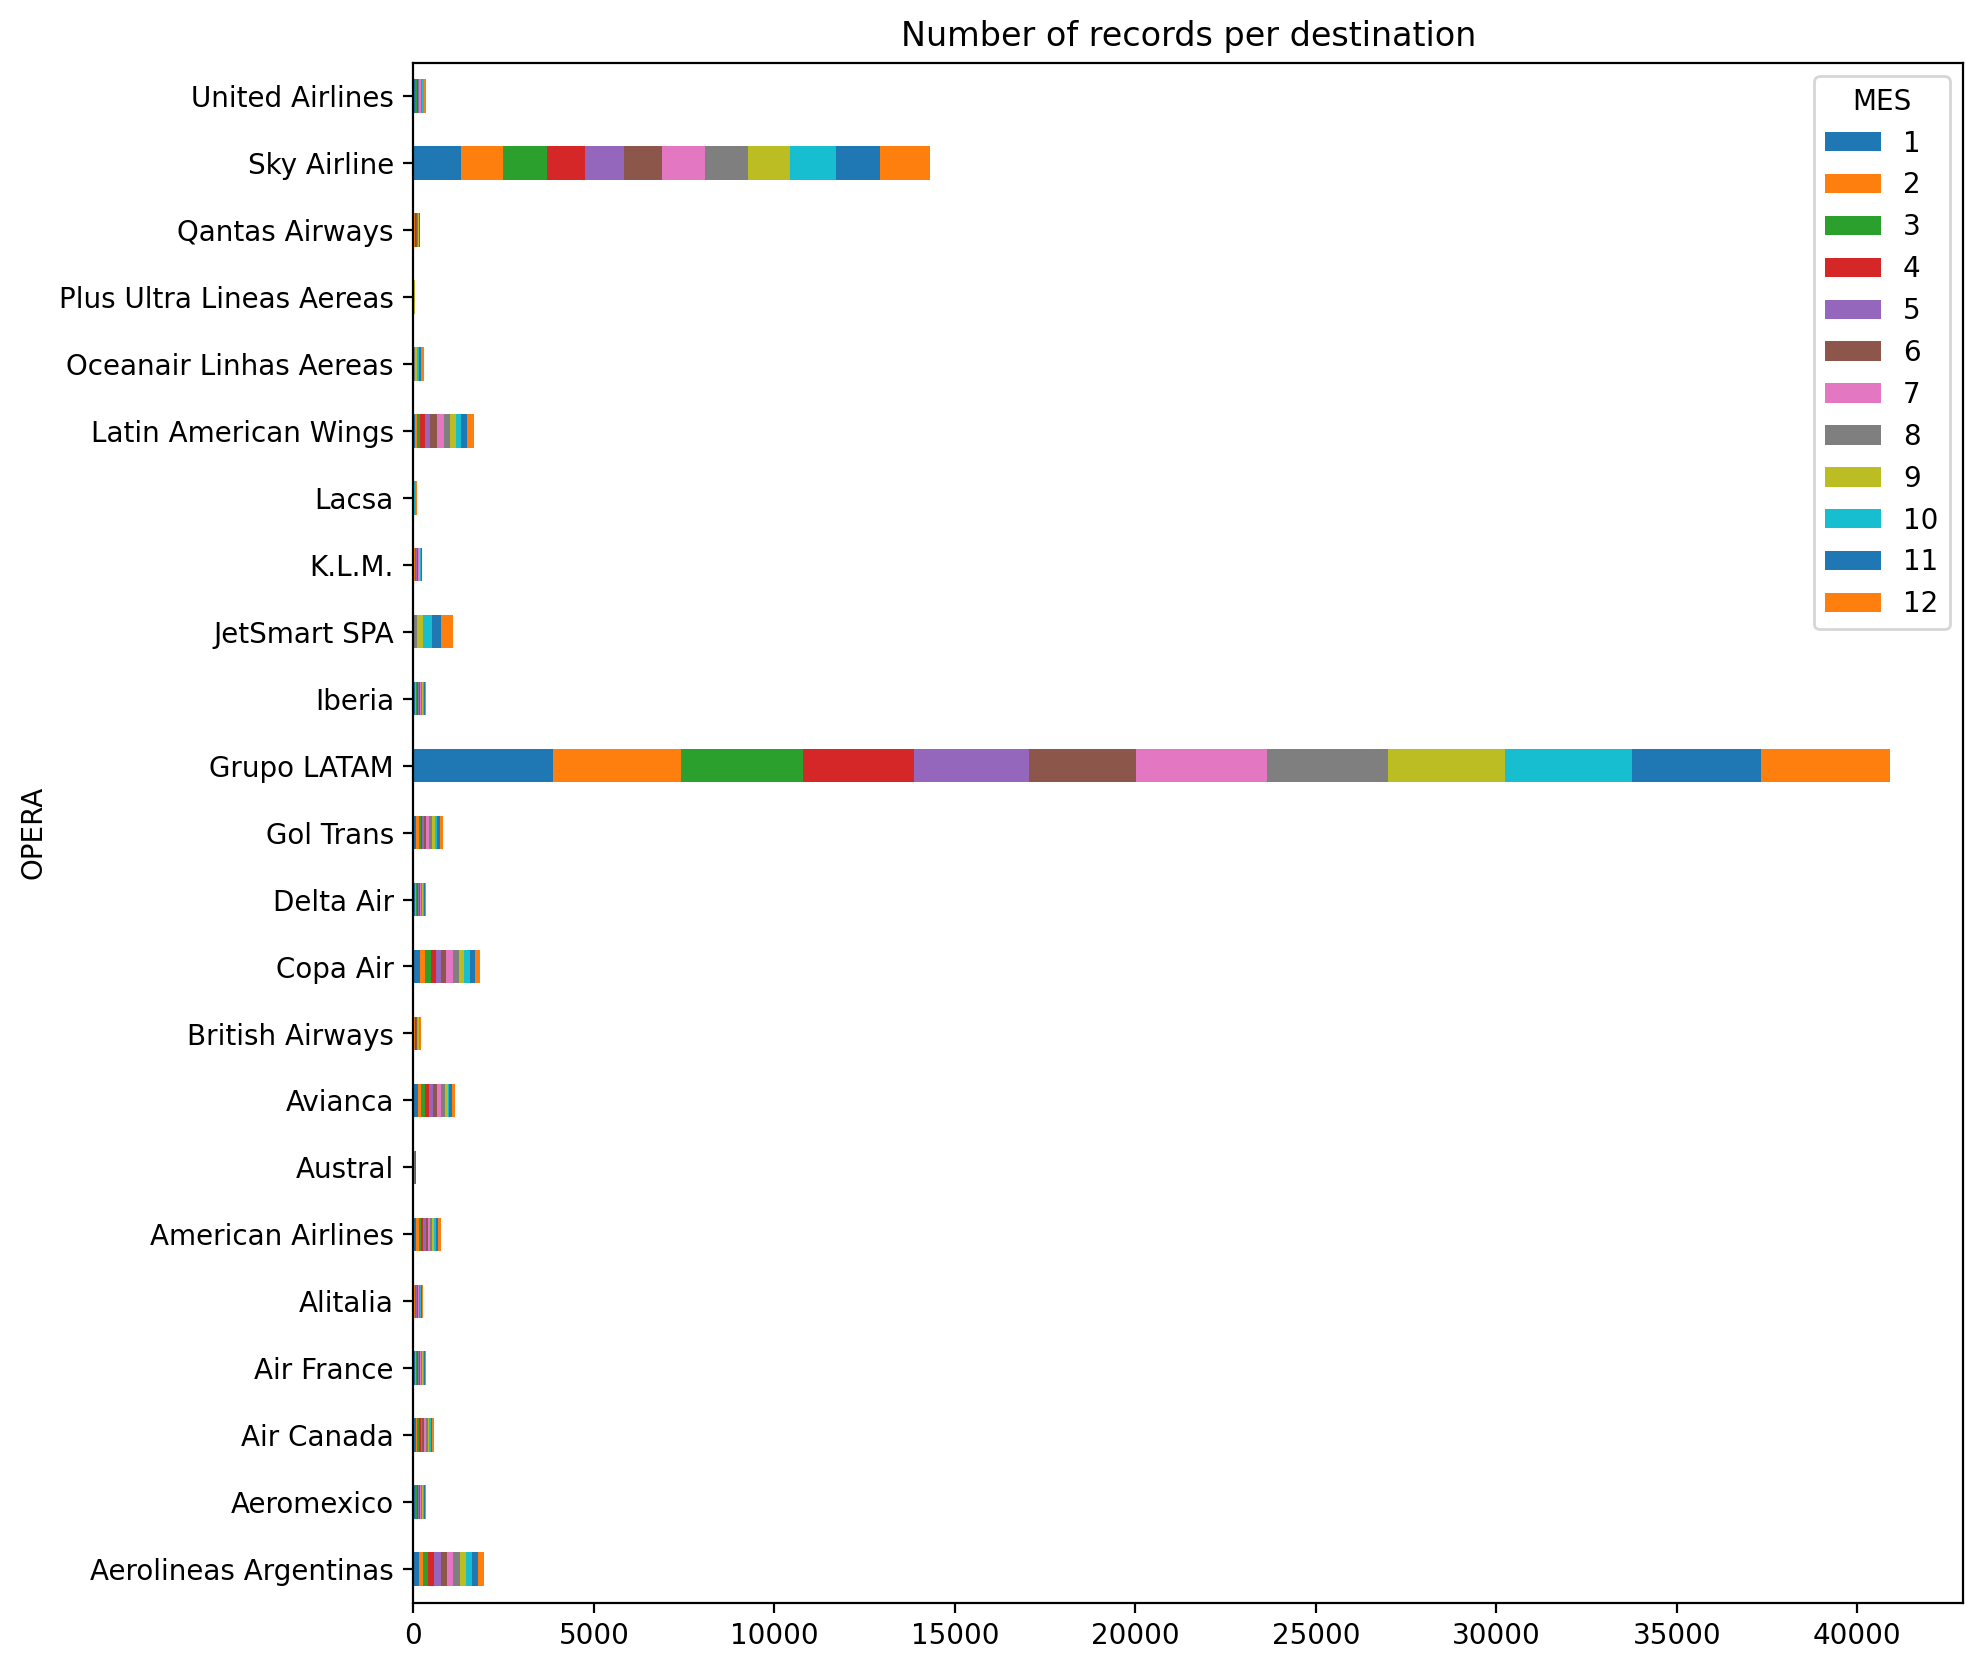

In [72]:
df.groupby(['OPERA',"MES"])['MES'].size().unstack().plot.barh(stacked=True, figsize=(10, 10), title='Number of records per destination');
# In general, the number of flights is periodic.

### 2. Generate the following additional columns. Please export them to a CSV file named synthetic_features.csv

In [27]:
# You can execute the preprocessing class as follows and get complete synthetic features:
prepro = preprocessing(folder_name + file_name)
prepro.pipeline() # complete pipeline for preprocessing
prepro.synthetic_features # synthetic features

The date format is correct
The date format is correct


high_season  min_diff period_day  delay_15
0              1.0       3.0      night         0
1              1.0       9.0      night         0
2              1.0       9.0      night         0
3              1.0       3.0      night         0
4              1.0      -2.0      night         0
...            ...       ...        ...       ...
68201          1.0      46.0  afternoon         1
68202          1.0      16.0  afternoon         1
68203          1.0      40.0  afternoon         1
68204          1.0      13.0  afternoon         0
68205          1.0       9.0  afternoon         0

[68206 rows x 4 columns]

But if you want see the steps of the pipeline you can follows the next steps

In [28]:
synthetic_features_steps = pd.DataFrame()

- high_season : 1 if Date-I is between Dec-15 and Mar-3, or Jul-15 and Jul-31, or Sep-11 and Sep-30, 0 otherwise.

In [34]:
range_season1 = ((df['Fecha-I'].dt.month == 12) & (df['Fecha-I'].dt.day >= 15)) | ((df['Fecha-I'].dt.month == 1) | (df['Fecha-I'].dt.month == 2) | ((df['Fecha-I'].dt.month == 3) & (df['Fecha-I'].dt.day <= 3)))
range_season2 = ((df['Fecha-I'].dt.month == 7) & (df['Fecha-I'].dt.day >= 15) & (df['Fecha-I'].dt.day <= 31))
range_season3 = ((df['Fecha-I'].dt.month == 9) & (df['Fecha-I'].dt.day >= 11) & (df['Fecha-I'].dt.day <= 30))

In [35]:
df.loc[range_season1 | range_season2 | range_season3,'high_season'] = 1 # high season
df.high_season = df.high_season.fillna(0) # low season

In [36]:
synthetic_features_steps['high_season'] = df.high_season

In [37]:
synthetic_features_steps

high_season
0              1.0
1              1.0
2              1.0
3              1.0
4              1.0
...            ...
68201          1.0
68202          1.0
68203          1.0
68204          1.0
68205          1.0

[68206 rows x 1 columns]

- min_diff : difference in minutes between Date-O and Date-I

In [38]:
df['min_diff'] = (df['Fecha-O']-df['Fecha-I'])/timedelta(minutes=1)
synthetic_features_steps['min_diff'] = df['min_diff']

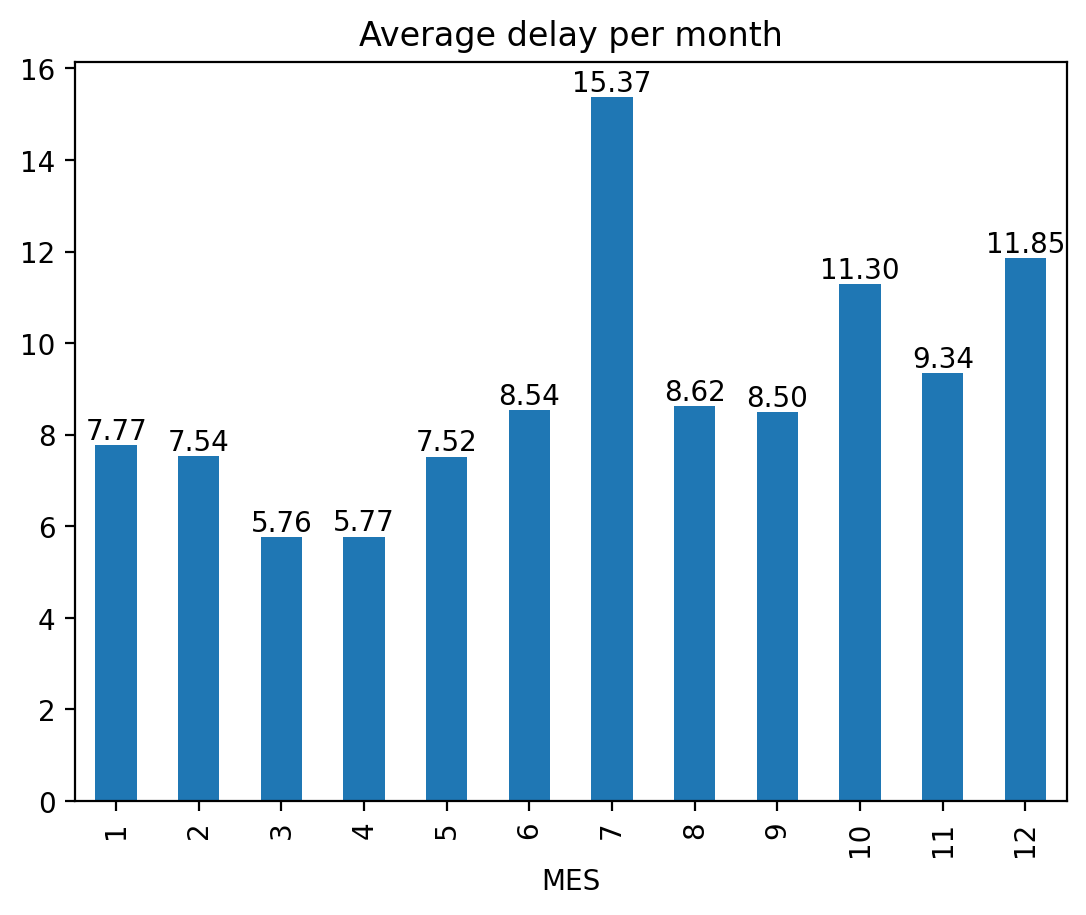

In [56]:
ax = df.groupby("MES")['min_diff'].mean().plot.bar()
ax.set_title('Average delay per month')
ax.bar_label(ax.containers[0],fmt='%.2f');

weather data could be a good feature to predict the delay, because the delay is higher in the winter season


In [46]:
data.loc[:,'MES'] = data.index.month
data_daily.loc[:,'MES'] = data_daily.index.month

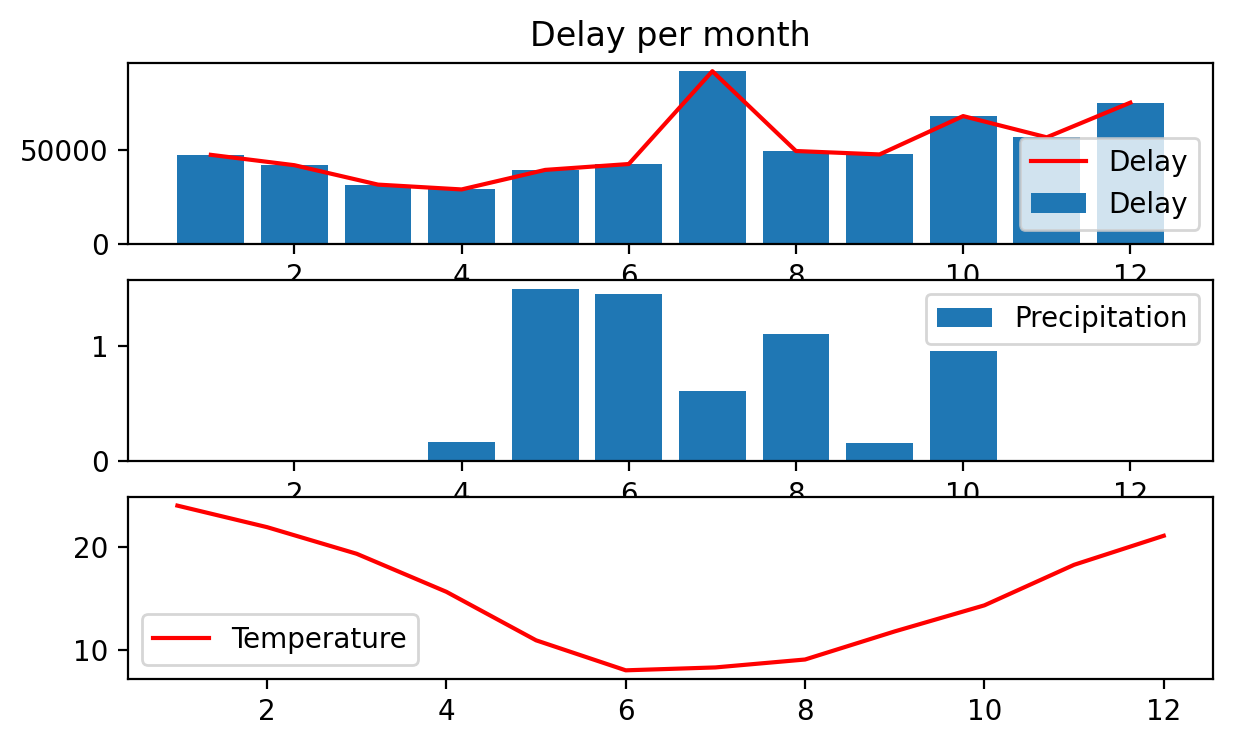

In [47]:
fig, axes = plt.subplots(3, 1, figsize=(7, 4))

axes[0].bar(df.groupby("MES")['min_diff'].sum().index, df.groupby("MES")['min_diff'].sum(), label = 'Delay')
axes[0].plot(df.groupby("MES")['min_diff'].sum().index, df.groupby("MES")['min_diff'].sum(), label = 'Delay' , c = 'r')
axes[1].bar(data_daily.groupby("MES")['prcp'].mean().index, data_daily.groupby("MES")['prcp'].mean() ,label = 'Precipitation')
axes[2].plot(data_daily.groupby("MES")['tavg'].mean().index, data_daily.groupby("MES")['tavg'].mean(), c = 'r', label = 'Temperature')

axes[0].legend()
axes[1].legend()
axes[2].legend()

axes[0].set_title('Delay per month');

- delay_15 : 1 if min_diff > 15, 0 if not.

In [48]:
synthetic_features_steps['delay_15'] = np.where(df['min_diff'].astype(float) > 15, 1, 0)
df['delay_15'] = np.where(df['min_diff'].astype(float) > 15, 1, 0)

In [49]:
synthetic_features_steps.delay_15.value_counts()

0    55592
1    12614
Name: delay_15, dtype: int64

In [50]:
synthetic_features_steps

high_season  min_diff  delay_15
0              1.0       3.0         0
1              1.0       9.0         0
2              1.0       9.0         0
3              1.0       3.0         0
4              1.0      -2.0         0
...            ...       ...       ...
68201          1.0      46.0         1
68202          1.0      16.0         1
68203          1.0      40.0         1
68204          1.0      13.0         0
68205          1.0       9.0         0

[68206 rows x 3 columns]

- period_day : morning (between 5:00 and 11:59), afternoon (between 12:00 and 18:59) and night (between 19:00 and 4:59), based
onDate-I

In [51]:
df.loc[((df['Fecha-I'].dt.hour>=5 )& (df['Fecha-I'].dt.hour<12)),'period_day'] = 'morning'
df.loc[((df['Fecha-I'].dt.hour>=12 )& (df['Fecha-I'].dt.hour<19)),'period_day'] = 'afternoon'
df.loc[((df['Fecha-I'].dt.hour>=19 )| (df['Fecha-I'].dt.hour<5)),'period_day'] = 'night'

In [52]:
df.period_day.value_counts()

afternoon    25506
morning      25352
night        17348
Name: period_day, dtype: int64

In [53]:
synthetic_features_steps['period_day'] = df.period_day

In [54]:
synthetic_features_steps

high_season  min_diff  delay_15 period_day
0              1.0       3.0         0      night
1              1.0       9.0         0      night
2              1.0       9.0         0      night
3              1.0       3.0         0      night
4              1.0      -2.0         0      night
...            ...       ...       ...        ...
68201          1.0      46.0         1  afternoon
68202          1.0      16.0         1  afternoon
68203          1.0      40.0         1  afternoon
68204          1.0      13.0         0  afternoon
68205          1.0       9.0         0  afternoon

[68206 rows x 4 columns]

In [115]:
synthetic_features_steps.to_csv('./synthetic_features.csv', index=False)

### 3. What is the behavior of the delay rate across destination, airline, month of the year, day of the week, season, type of flight?What variables would you expect to have the most influence in predicting delays?

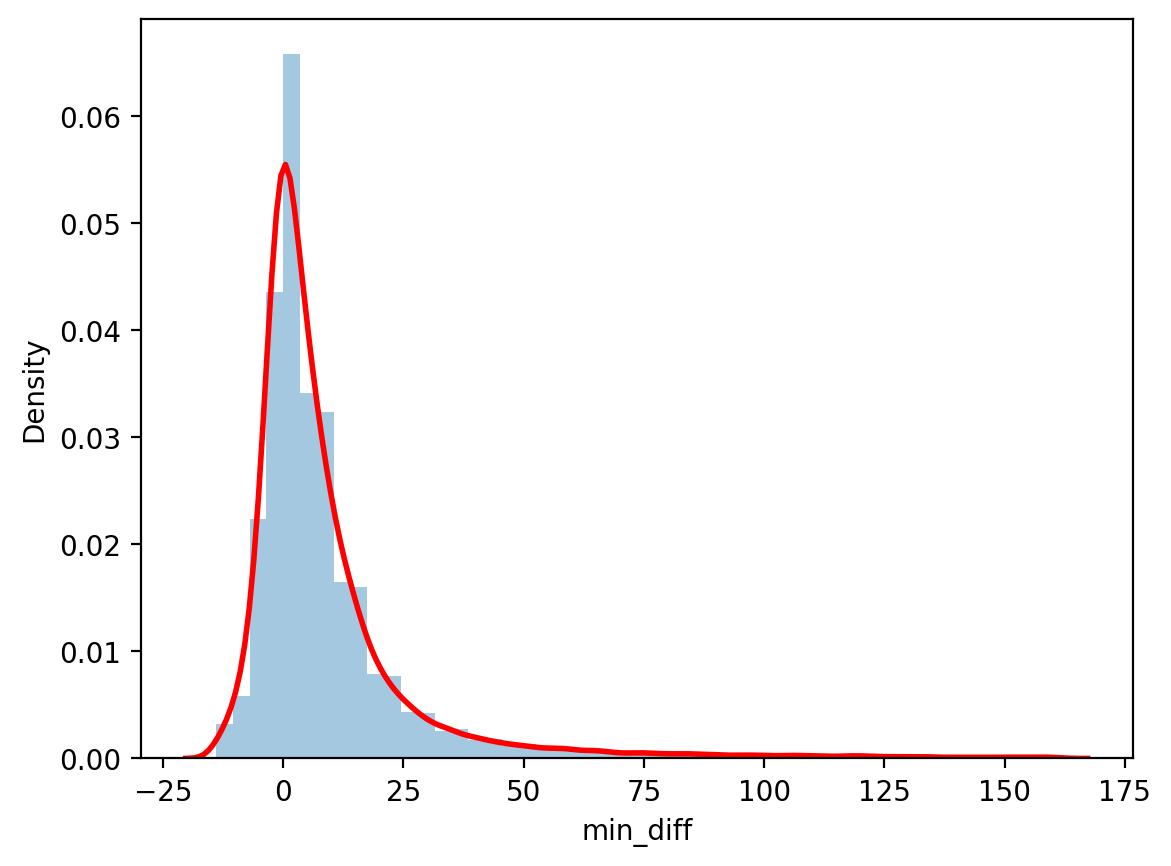

In [59]:
# plot the histogram with trend line using seaborn
sns.distplot(df.min_diff, kde=True, kde_kws={'color': 'red', 'linewidth': 2})
#sns.distplot(df[df.min_diff<0].min_diff, kde=True, kde_kws={'color': 'red', 'linewidth': 2})
# display the plot
plt.show()

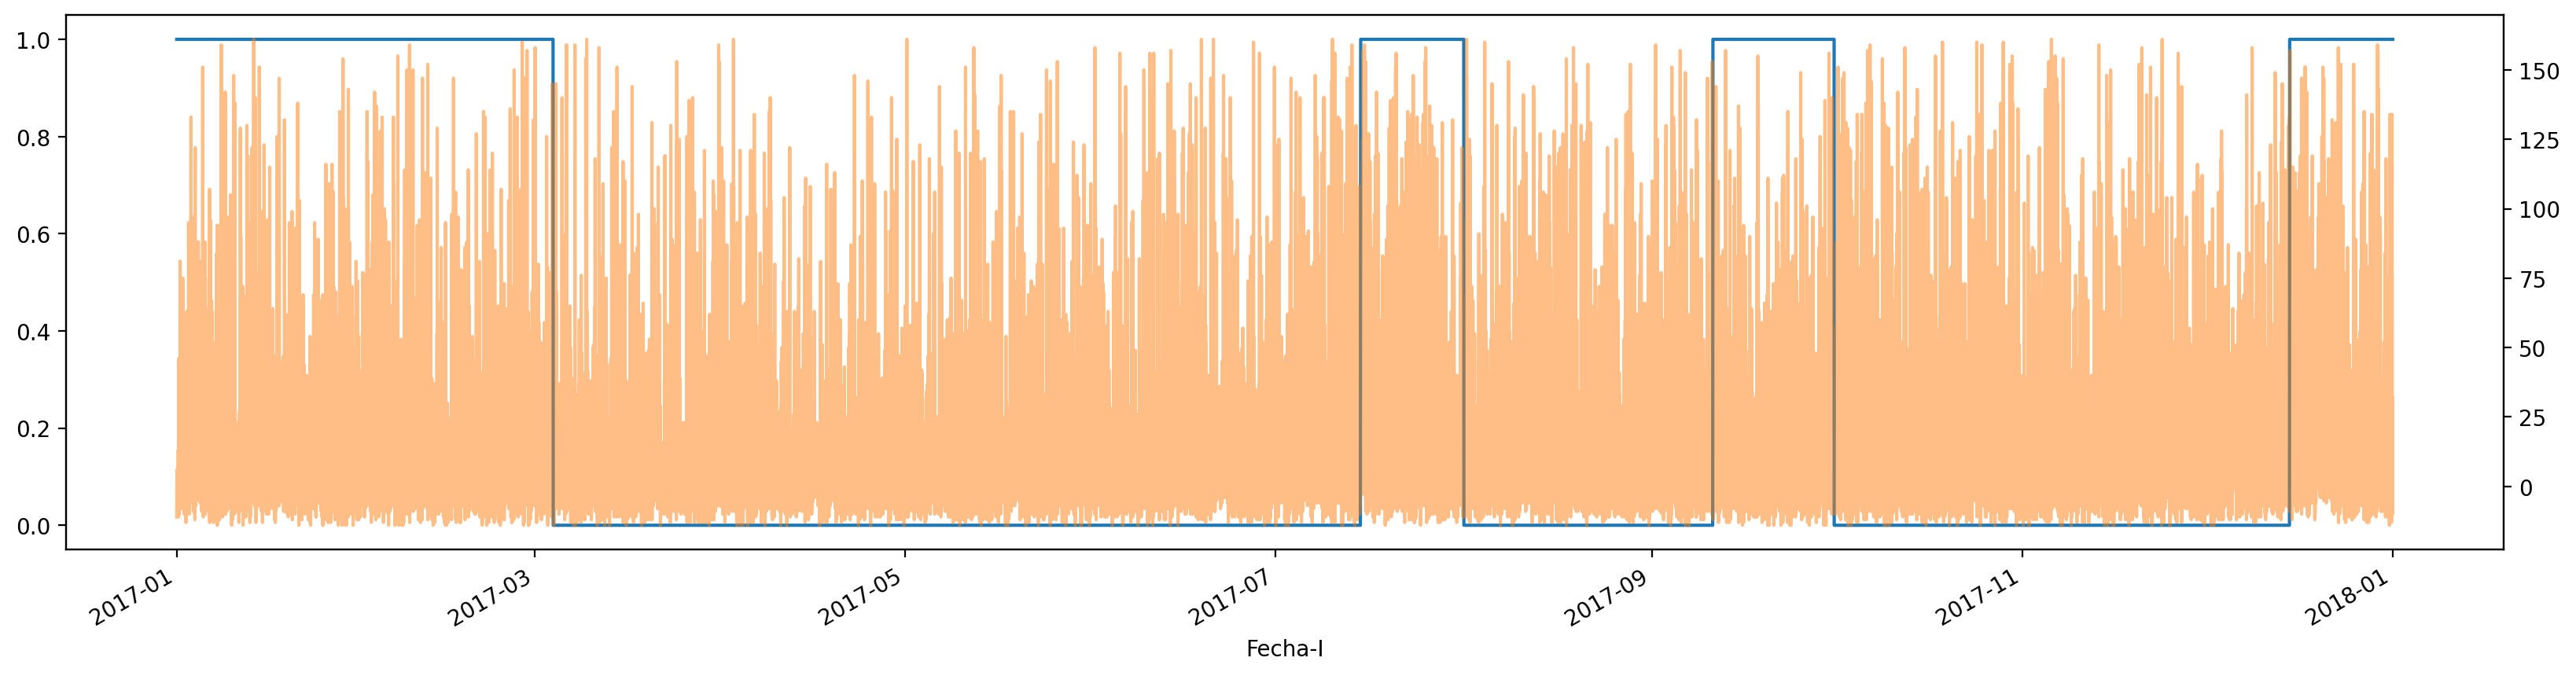

In [60]:
ax = df.set_index('Fecha-I').high_season.plot(figsize=(20,5))
df.set_index('Fecha-I').min_diff.plot(ax=ax,secondary_y=True, alpha=0.5);

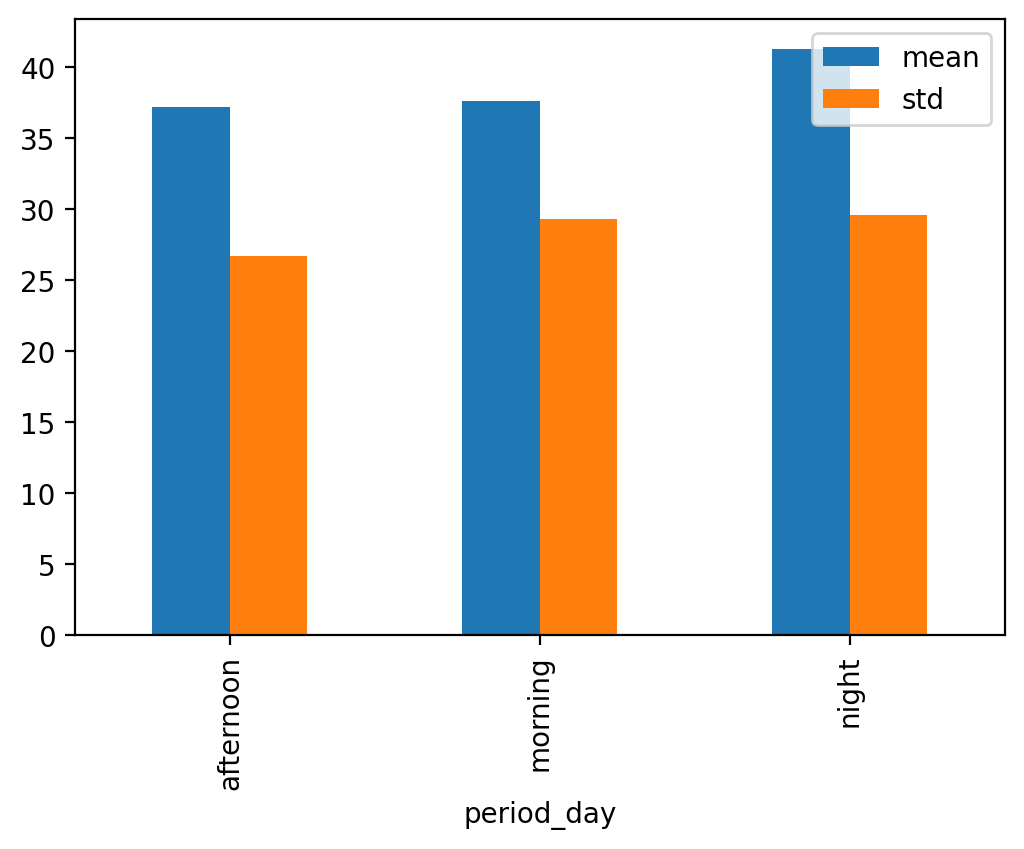

In [63]:
df[df.delay_15==1].groupby(['period_day'])['min_diff'].agg(["mean","std"]).plot.bar(figsize=(6,4)); # Periods of the day do not appear to be significant.

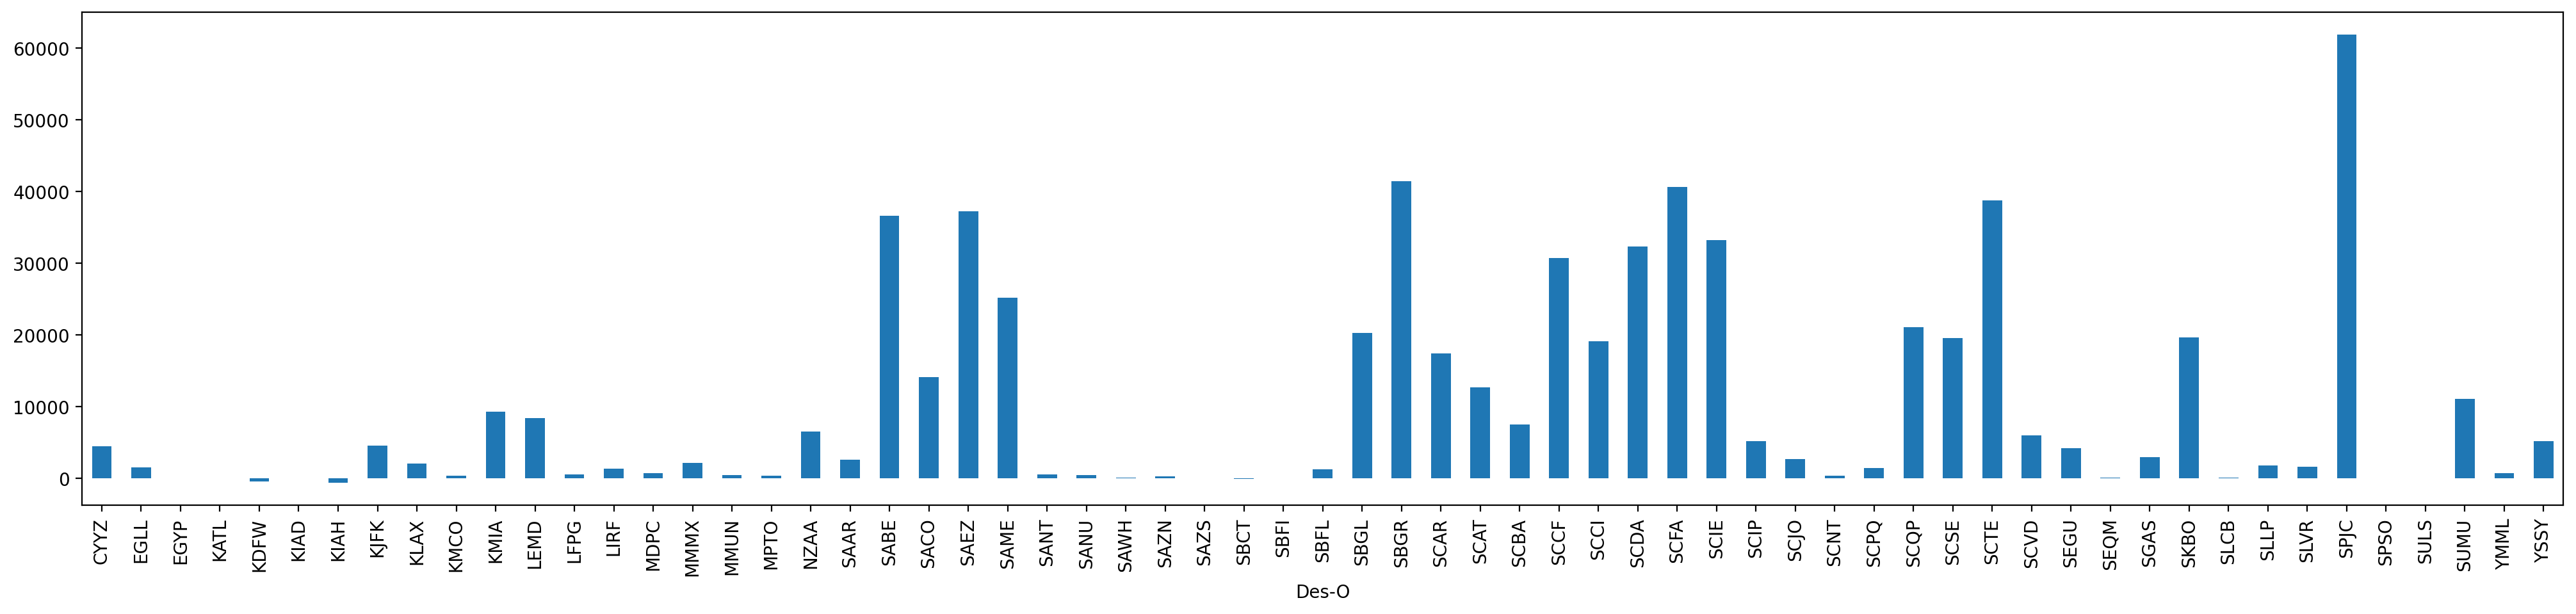

In [64]:
df.groupby('Des-O')['min_diff'].sum().plot.bar(figsize=(25,5));

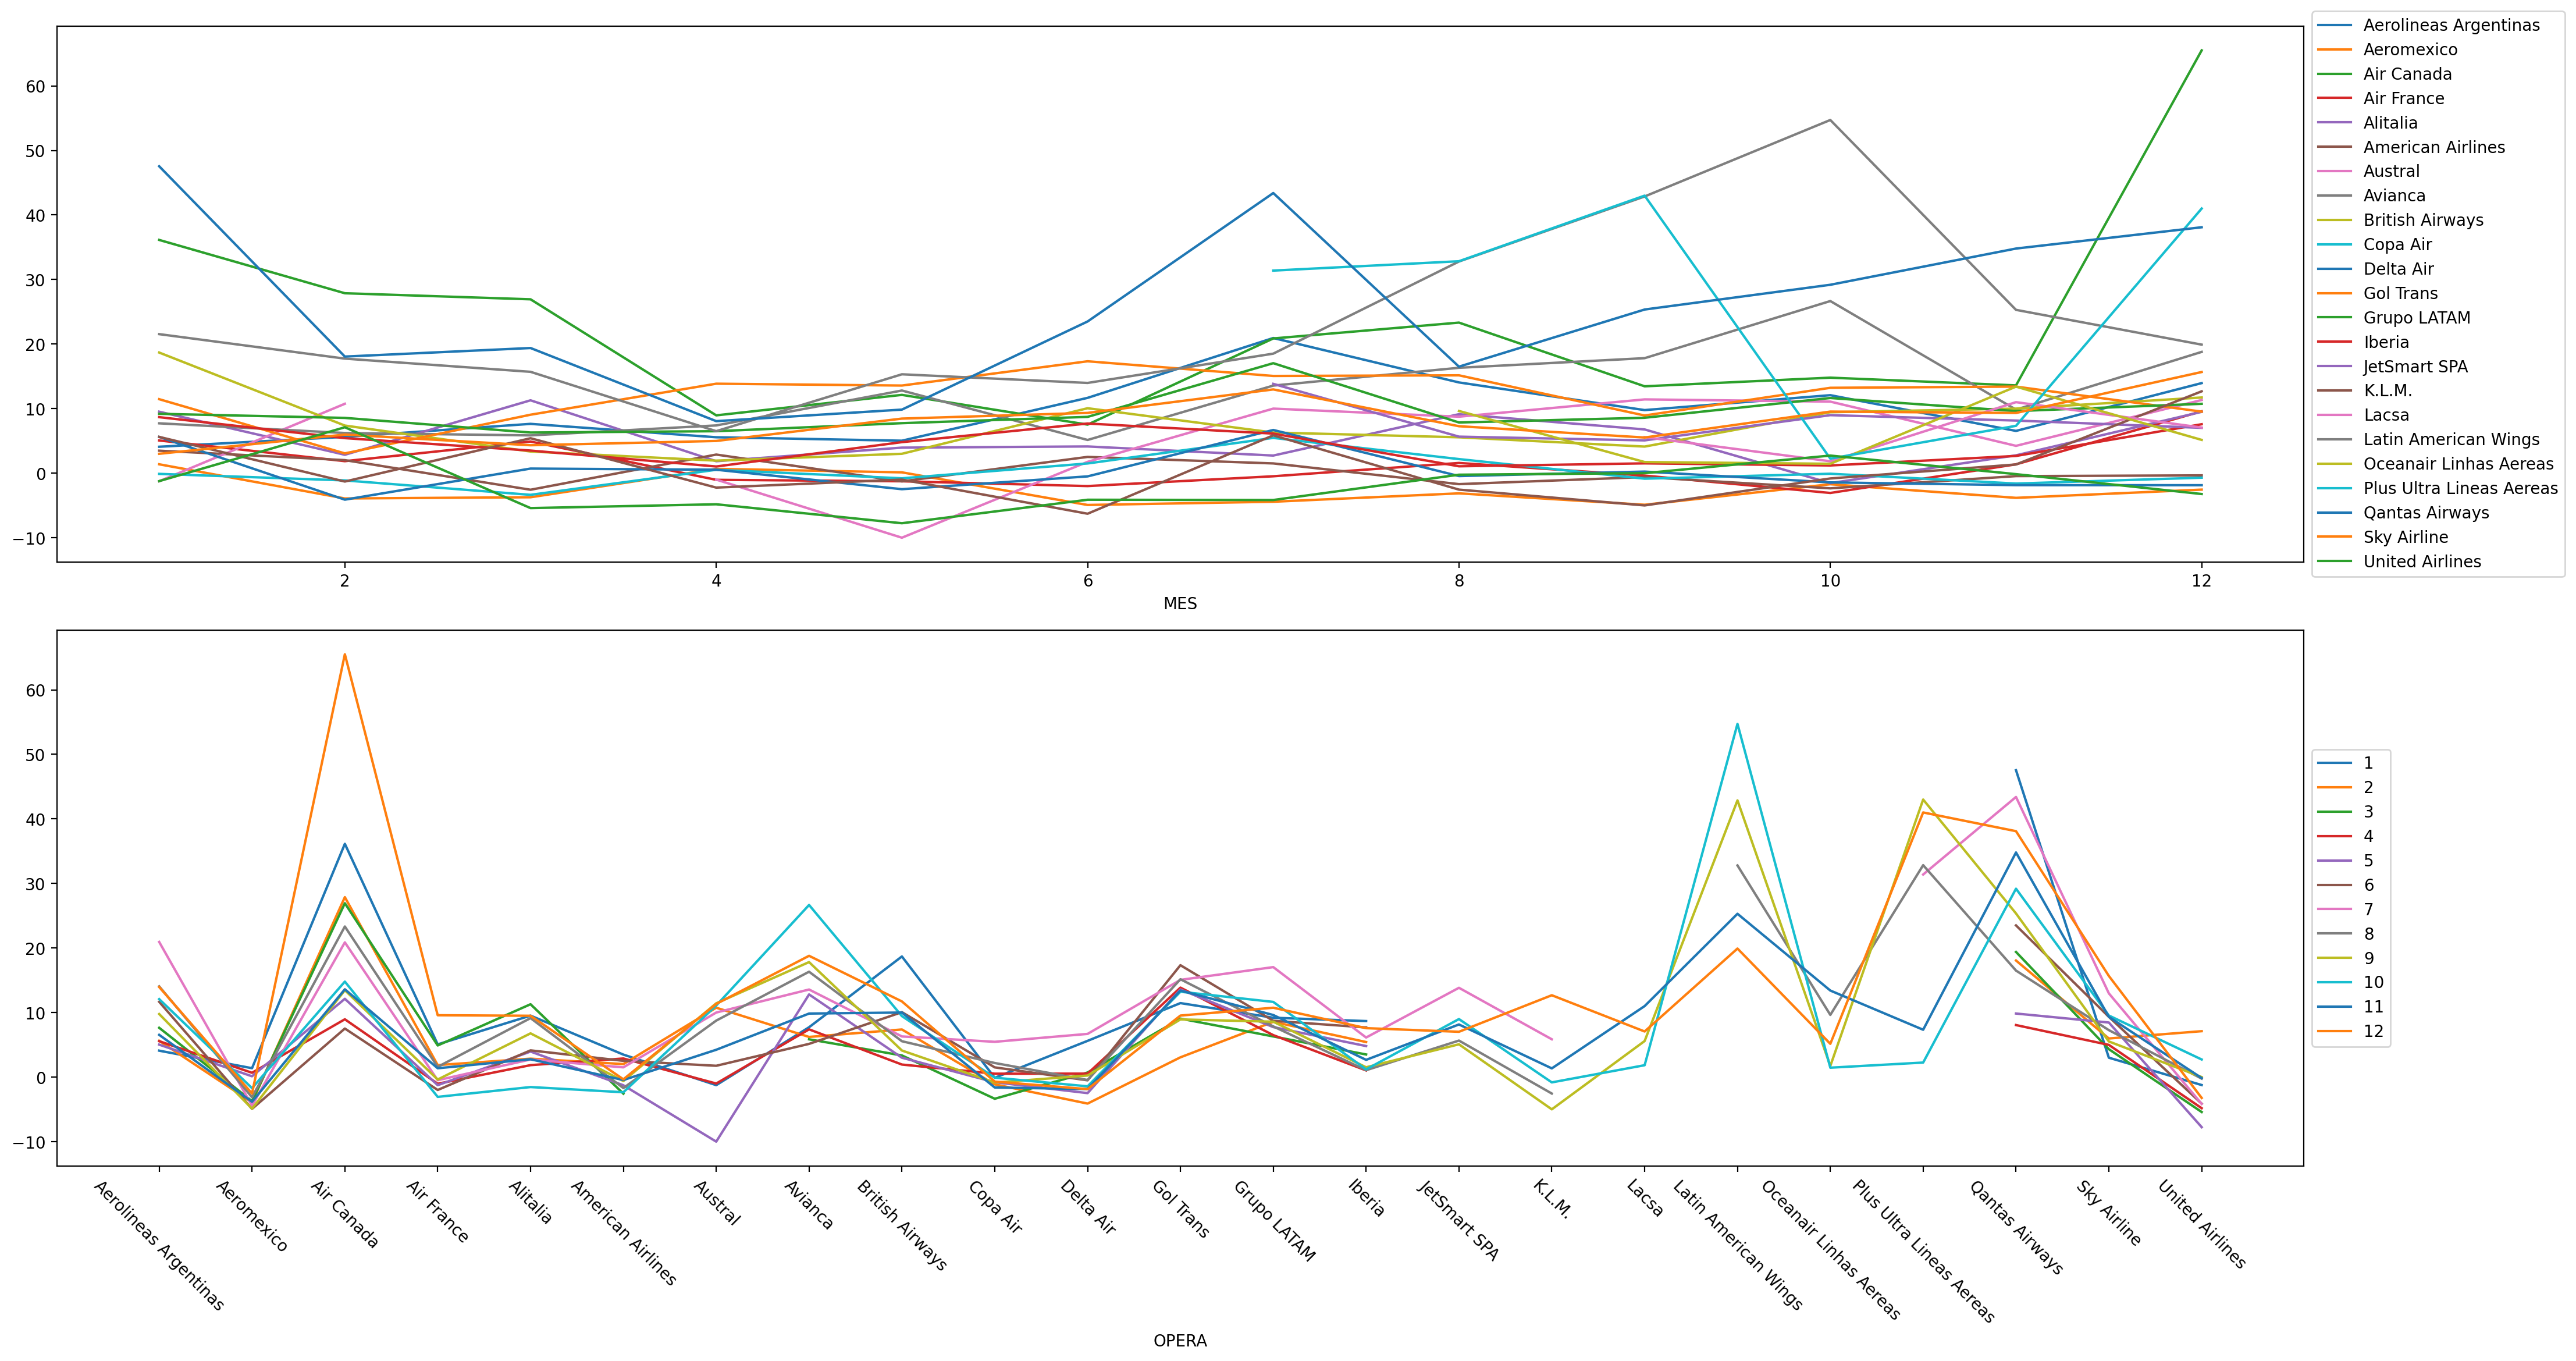

In [140]:
grouped_data = df.groupby(['MES','OPERA'],as_index=False)['min_diff'].mean()
cols = pd.pivot_table(grouped_data, values='min_diff', index='MES', columns='OPERA').columns.tolist()

fig,axes = plt.subplots(2,1,figsize=(20,12))
pd.pivot_table(grouped_data, values='min_diff', index='OPERA', columns='MES').plot(ax=axes[1])
pd.pivot_table(grouped_data, values='min_diff', index='MES', columns='OPERA').plot(ax=axes[0],legend=True)

box = axes[0].get_position()
box_0 = axes[1].get_position()


# Put a legend to the right of the current axis
axes[0].set_position([box.x0, box.y0, box.width * 0.8, box.height])
axes[1].set_position([box_0.x0, box_0.y0, box_0.width * 0.8, box_0.height])

# Put a legend to the right of the current axis
axes[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

axes[1].set_xticks(np.arange(len(grouped_data.OPERA.unique())))
axes[1].set_xticklabels(cols)
axes[1].tick_params(axis='x', labelrotation=-45)
fig.tight_layout()

<Axes: xlabel='MES'>

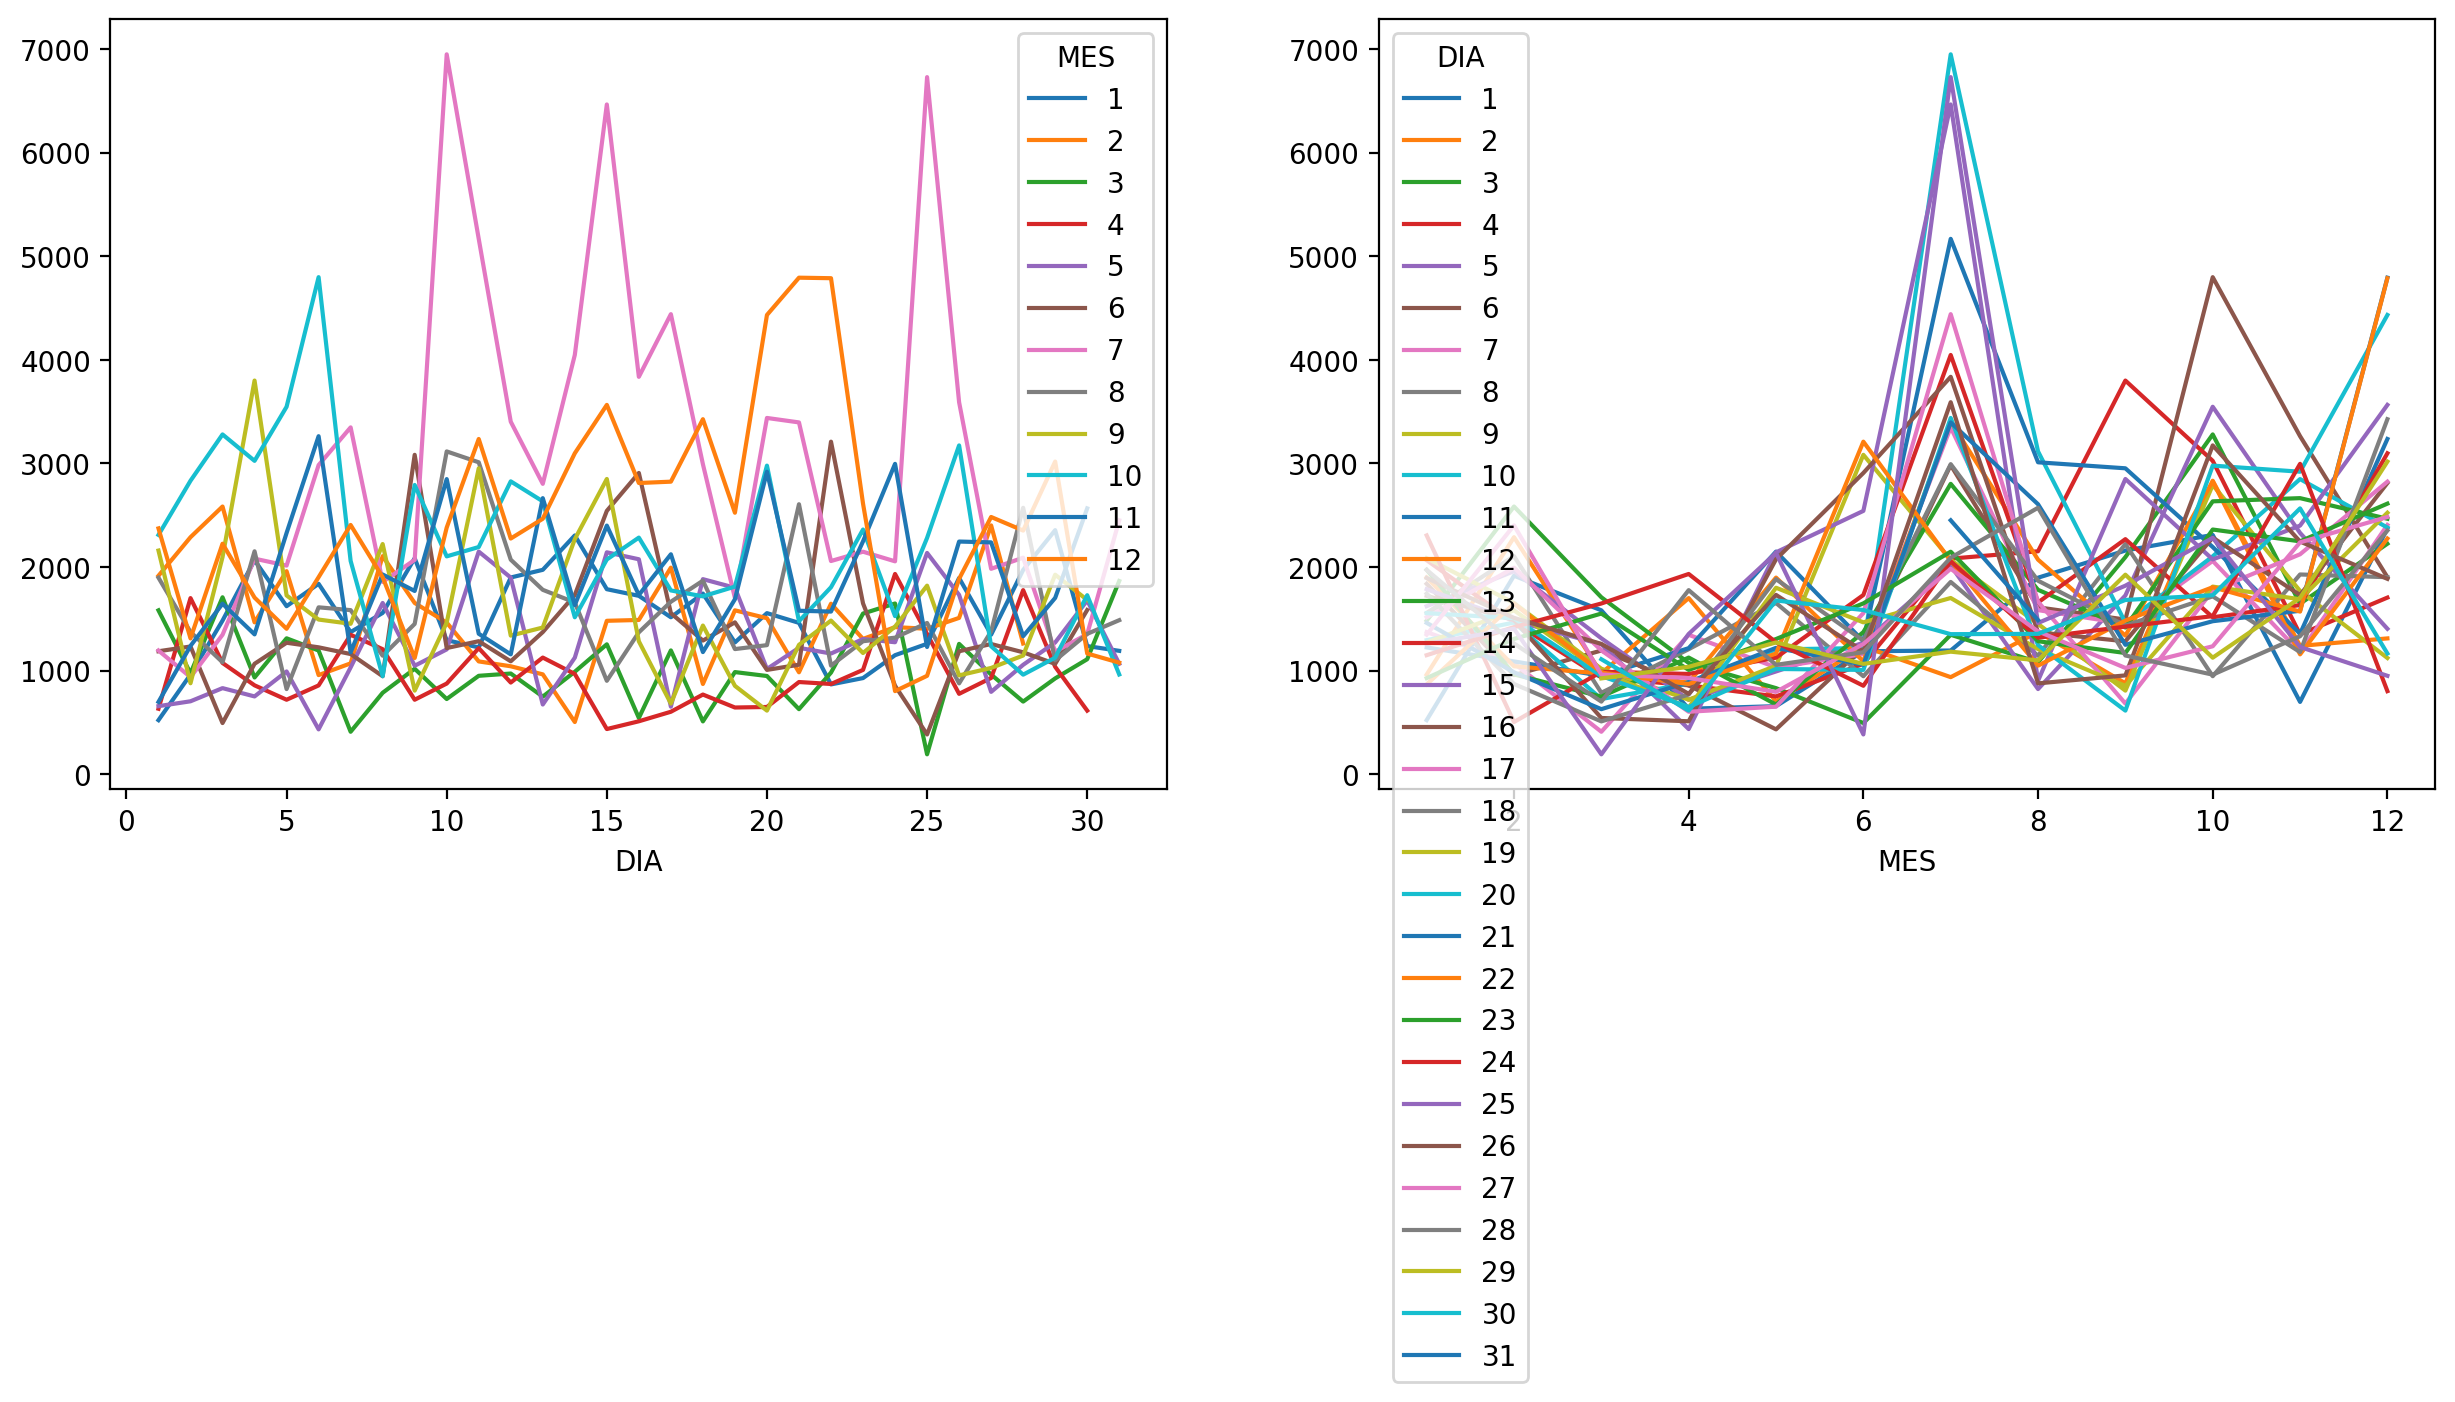

In [649]:
grouped_data = df.groupby(['MES','DIA'],as_index=False)['min_diff'].sum()

fig,axes = plt.subplots(1,2,figsize=(15,5))
pd.pivot_table(grouped_data, values='min_diff', index='DIA', columns='MES').plot(ax=axes[0])
pd.pivot_table(grouped_data, values='min_diff', index='MES', columns='DIA').plot(ax=axes[1],legend=True)

<Axes: xlabel='OPERA'>

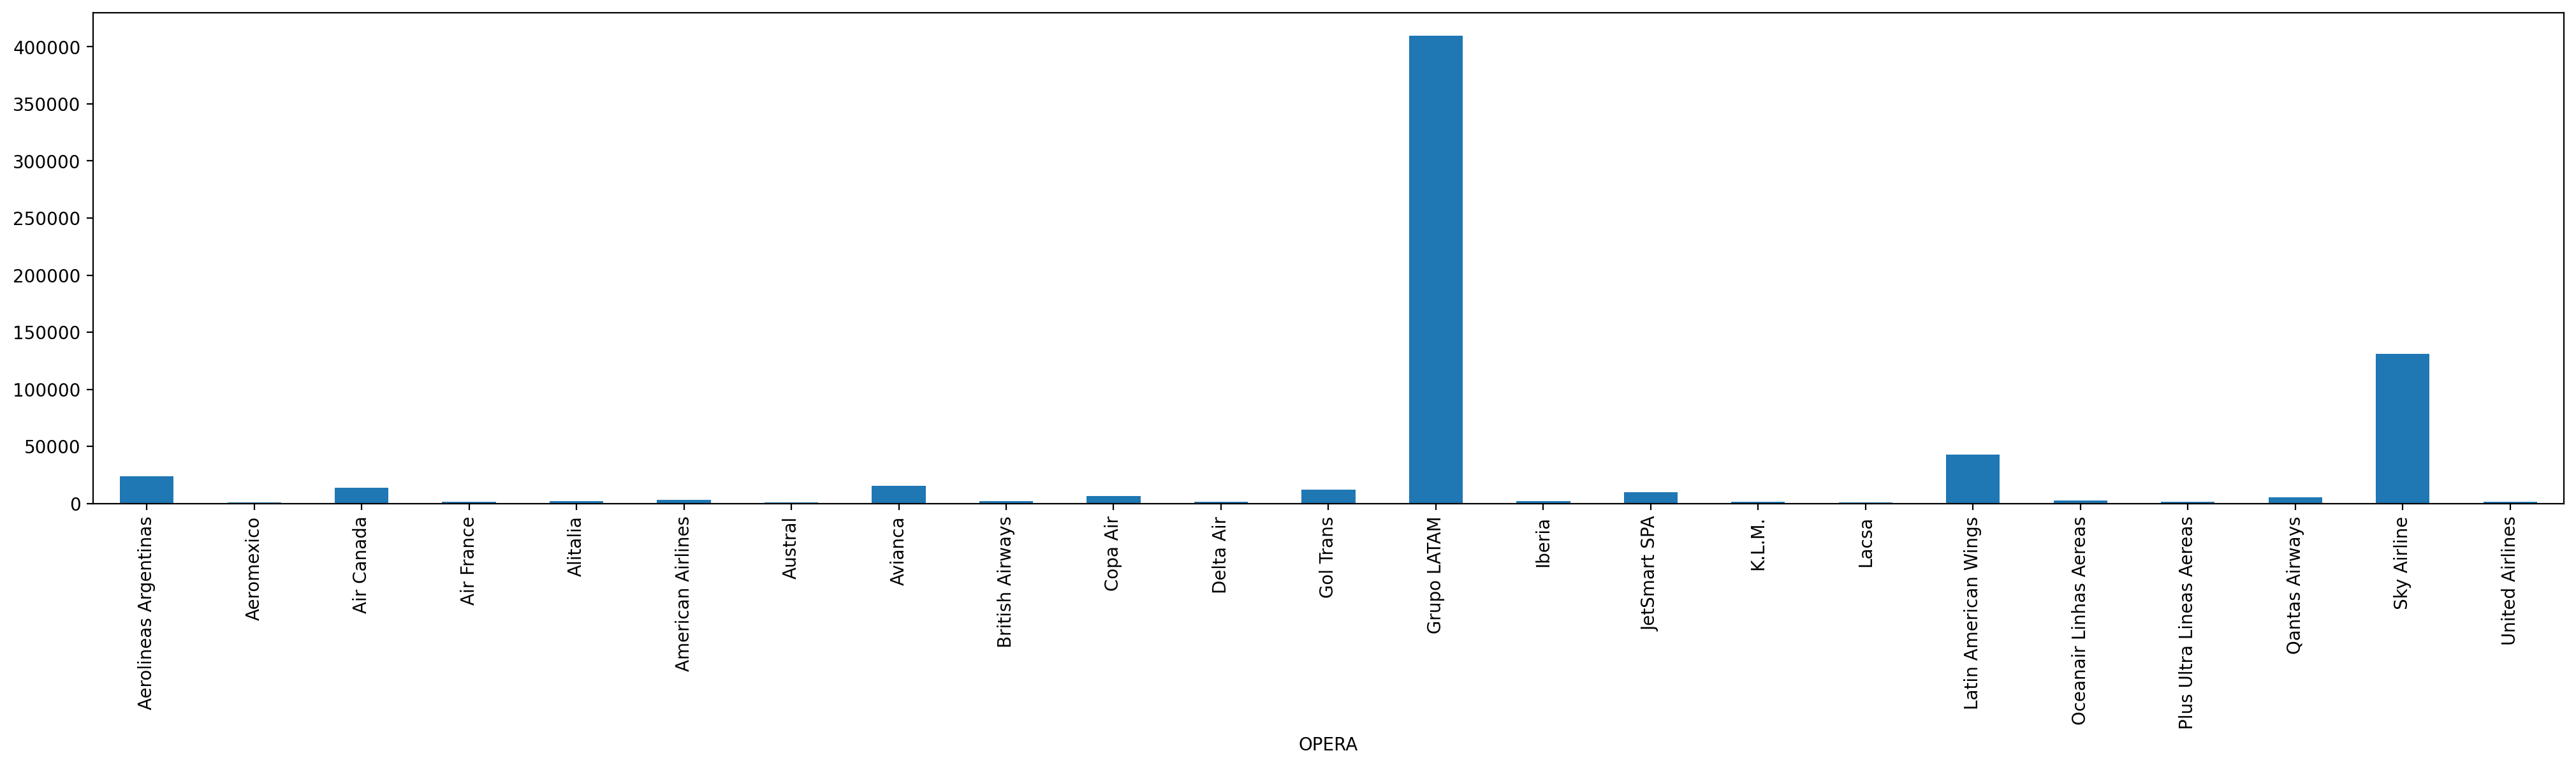

In [142]:
df[df.min_diff.ge(0)].groupby('OPERA')['min_diff'].sum().plot.bar(figsize=(25,5)) 


<Axes: xlabel='OPERA'>

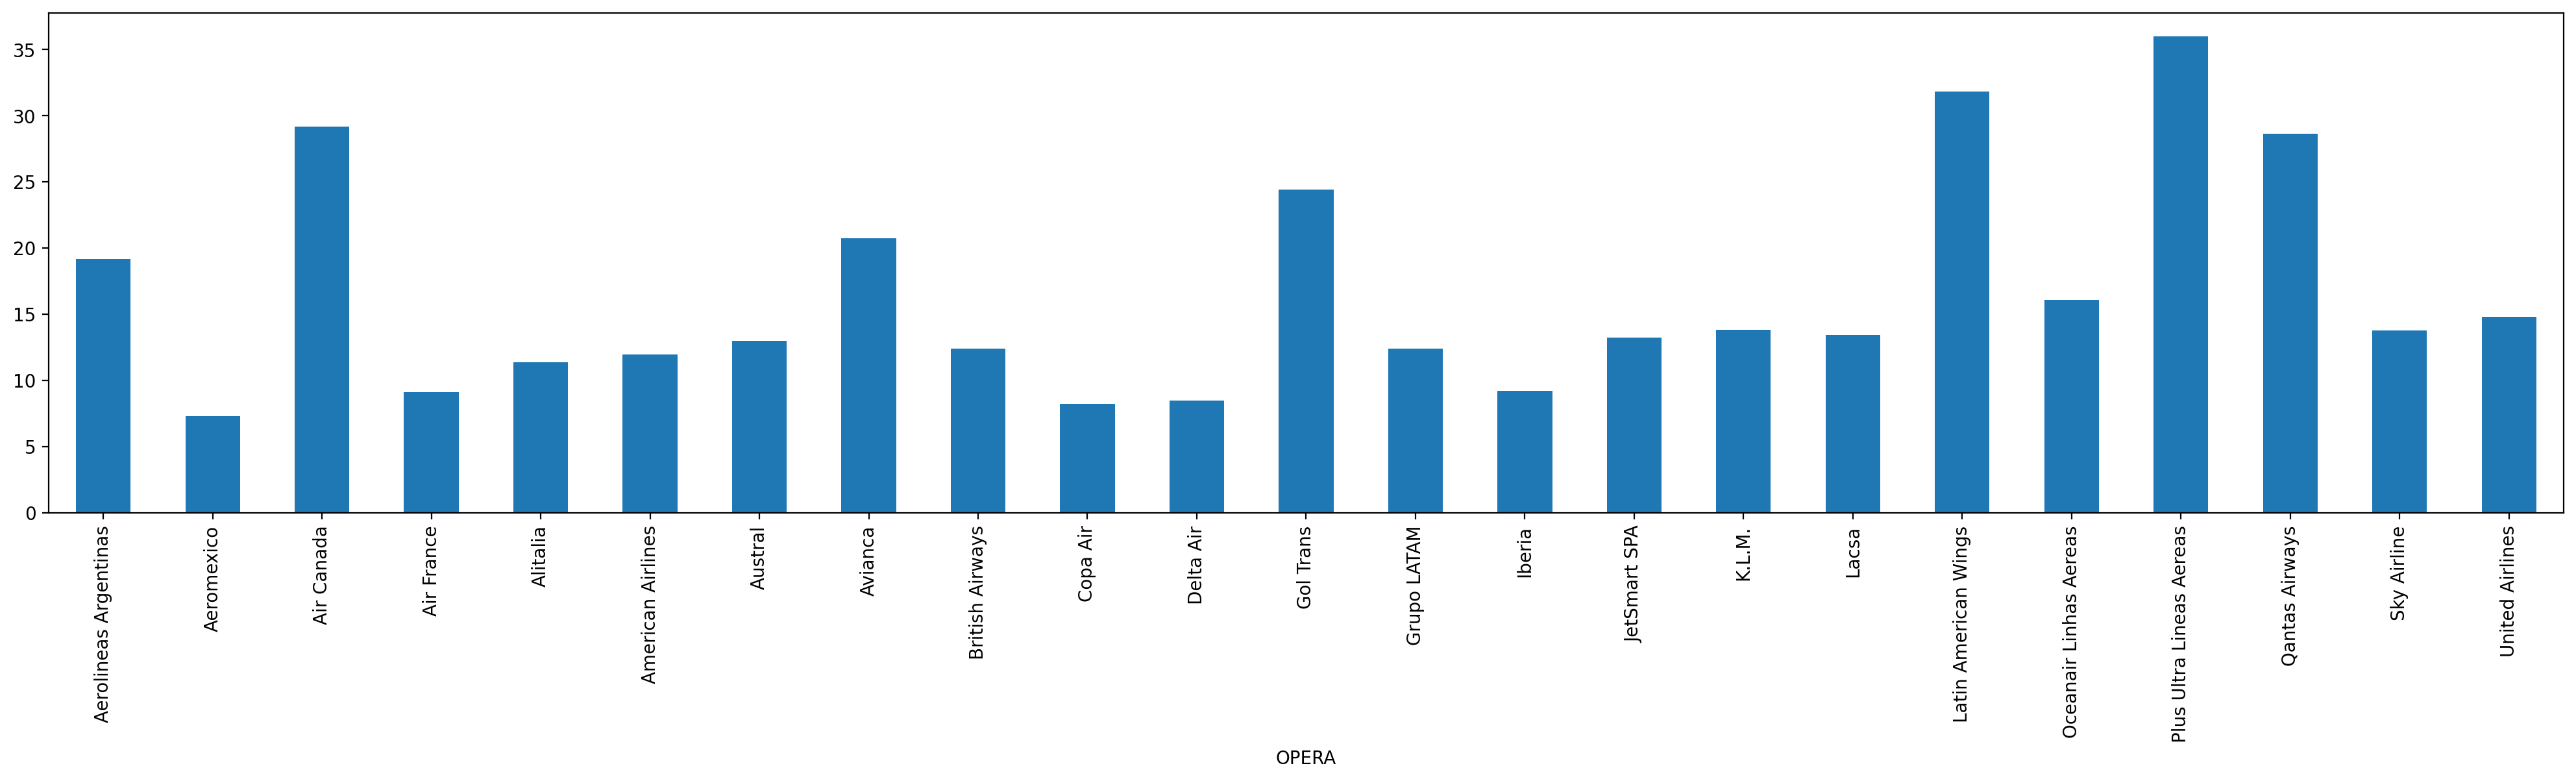

In [141]:
df[df.min_diff.ge(0)].groupby('OPERA')['min_diff'].mean().plot.bar(figsize=(25,5))

Days has no clear relationship to differences in minutes

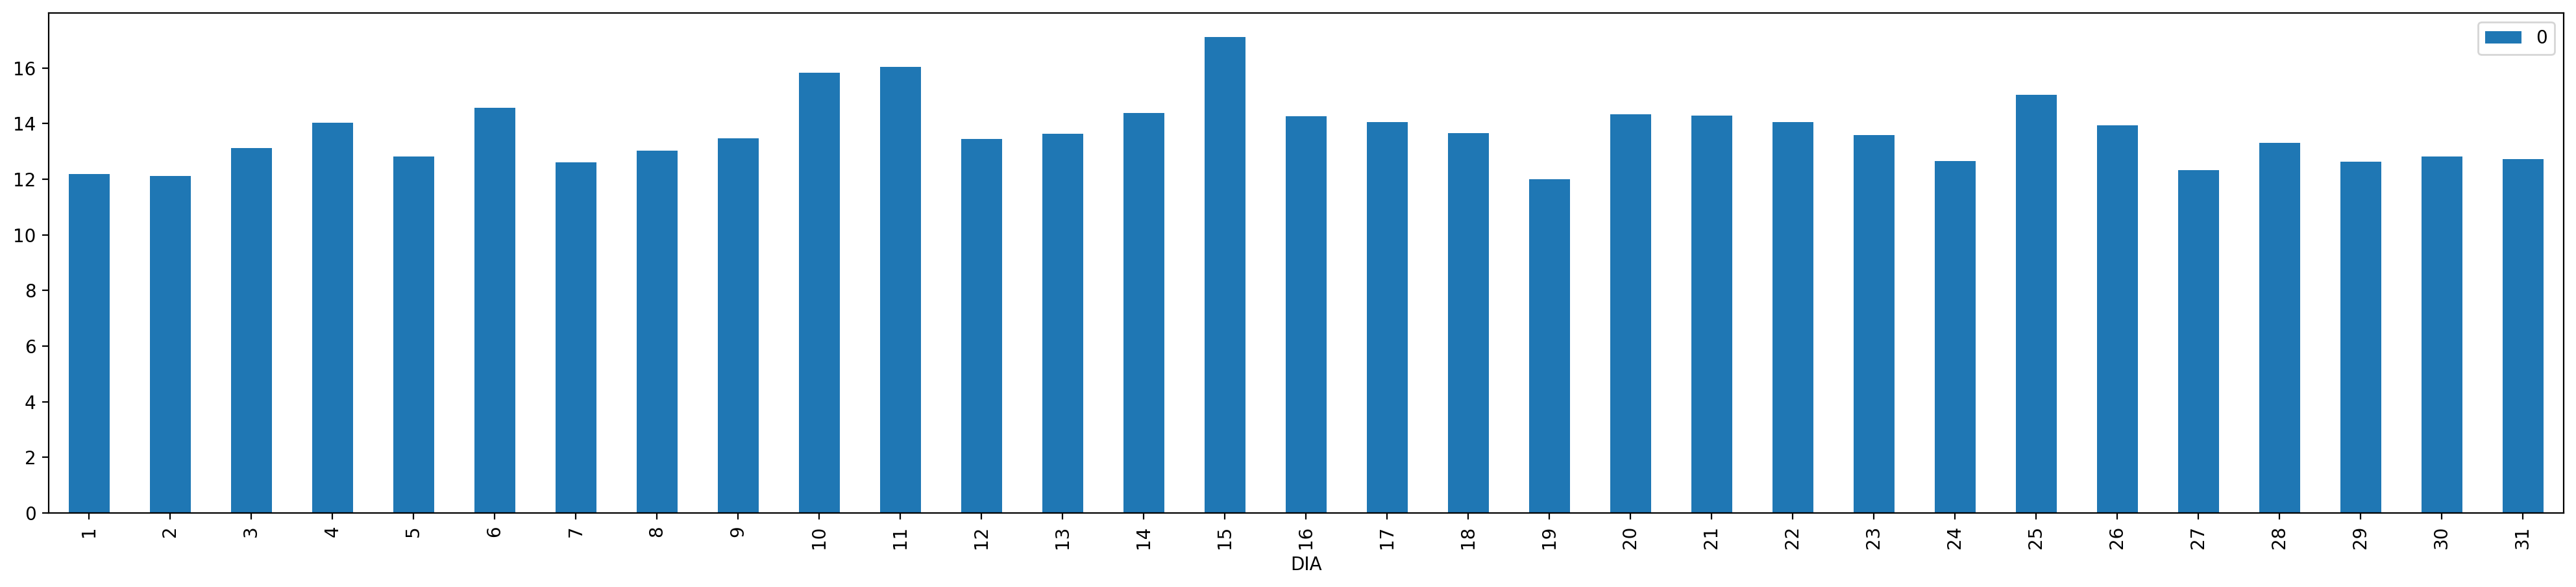

In [144]:
df[df.min_diff.ge(0)].groupby(['DIA'])['min_diff'].agg(["mean"]).unstack(level=0).reset_index(level=0).plot.bar(figsize=(25,5));

In the below plot, we can see that the delay is more on the fridays.

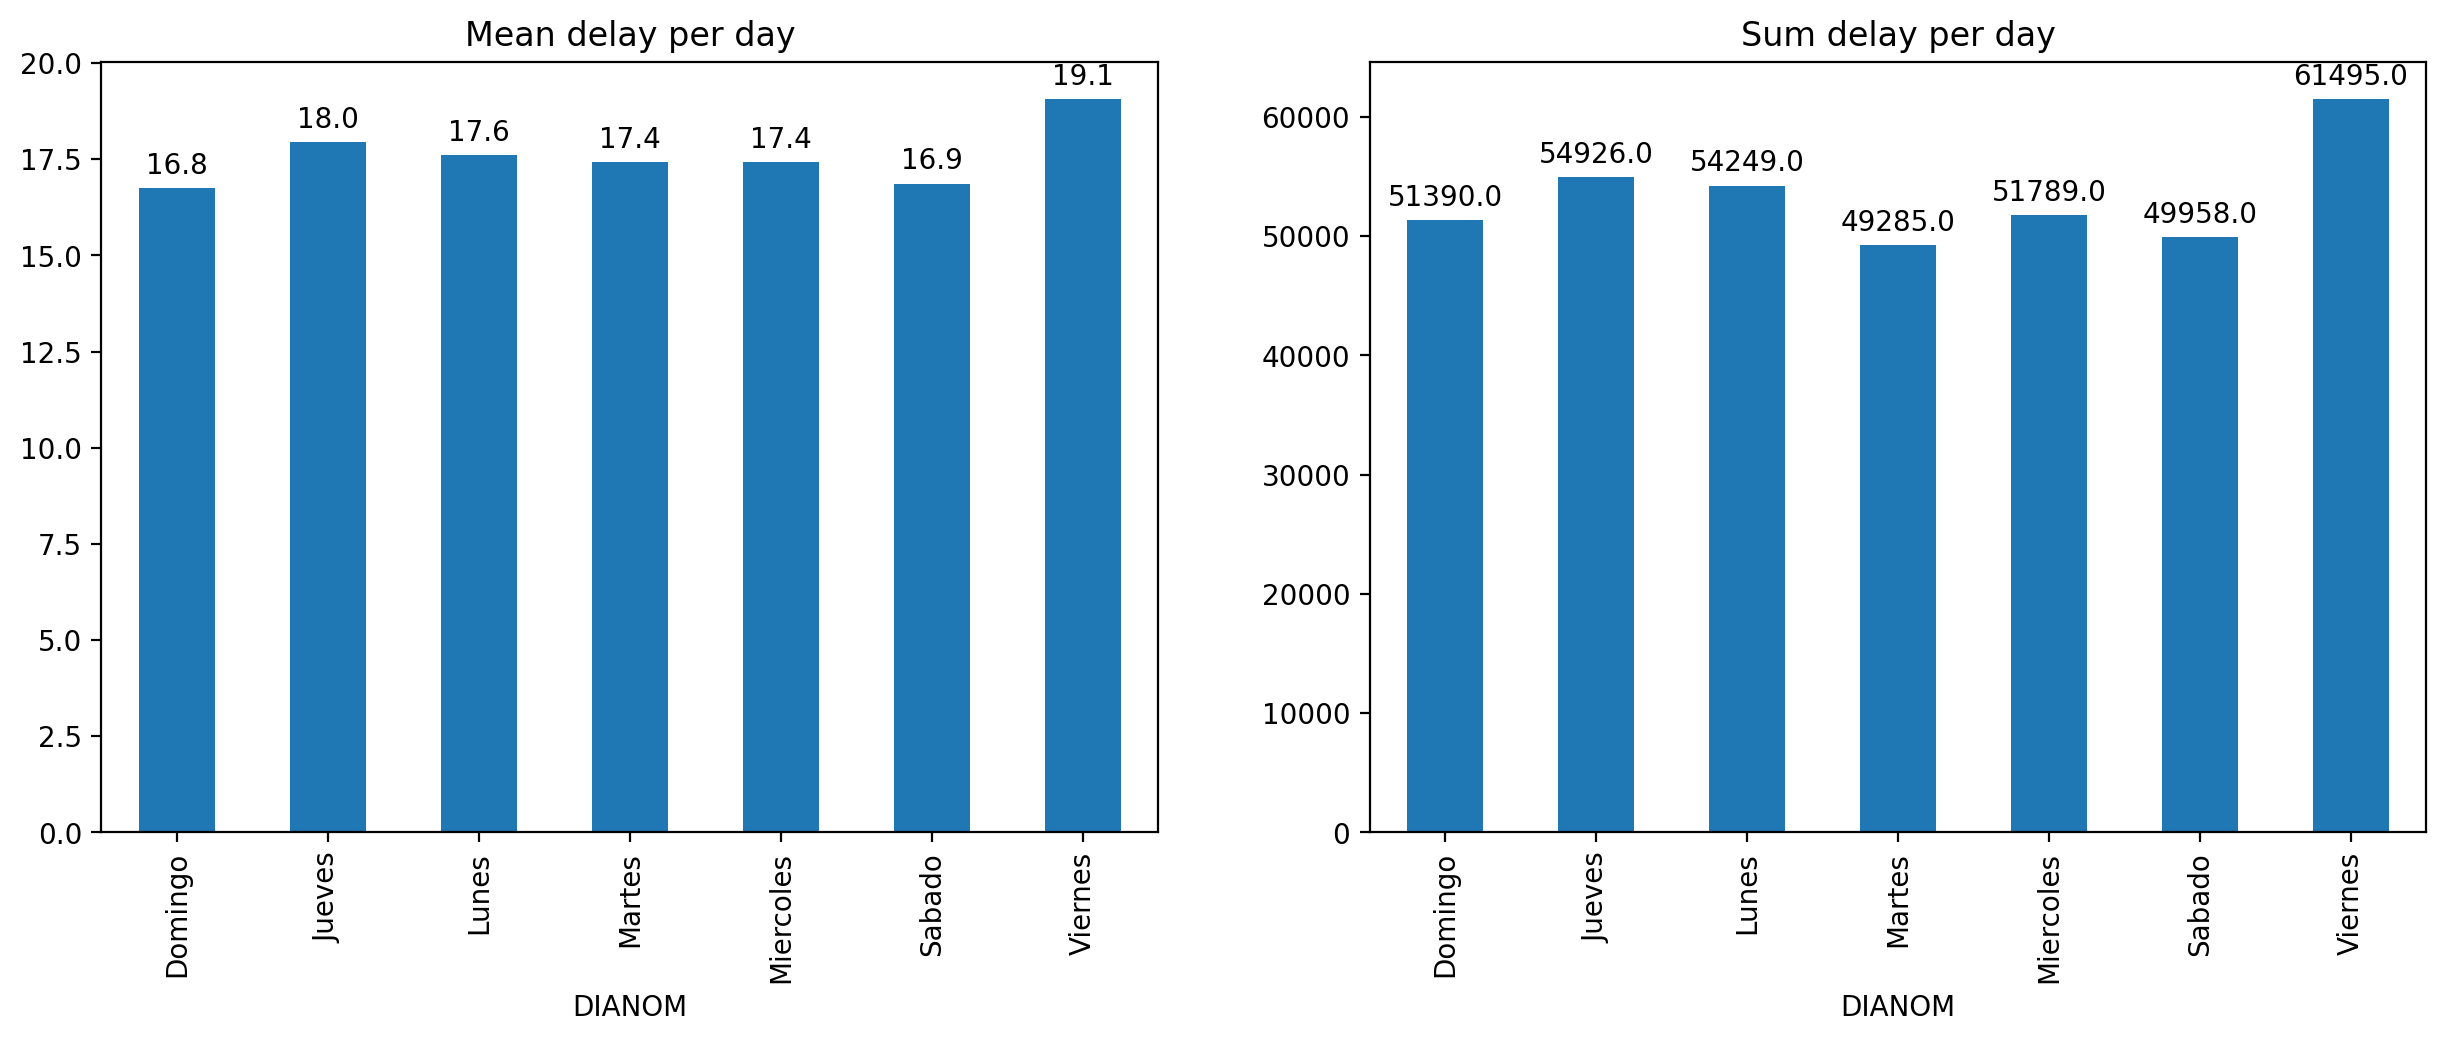

In [72]:
fig,axes = plt.subplots(1,2,figsize=(15,5))
df[df.min_diff.ge(0)][(df.TIPOVUELO=='I')&(df.min_diff>0)].groupby('DIANOM')['min_diff'].mean().plot.bar(ax = axes[0])
df[df.min_diff.ge(0)][(df.TIPOVUELO=='I')&(df.min_diff>0)].groupby('DIANOM')['min_diff'].sum().plot.bar(ax = axes[1])

axes[0].bar_label(axes[0].containers[0], fmt='%1.1f', padding=3)
axes[1].bar_label(axes[1].containers[0], fmt='%1.1f', padding=3)

axes[0].set_title('Mean delay per day')
axes[1].set_title('Sum delay per day');

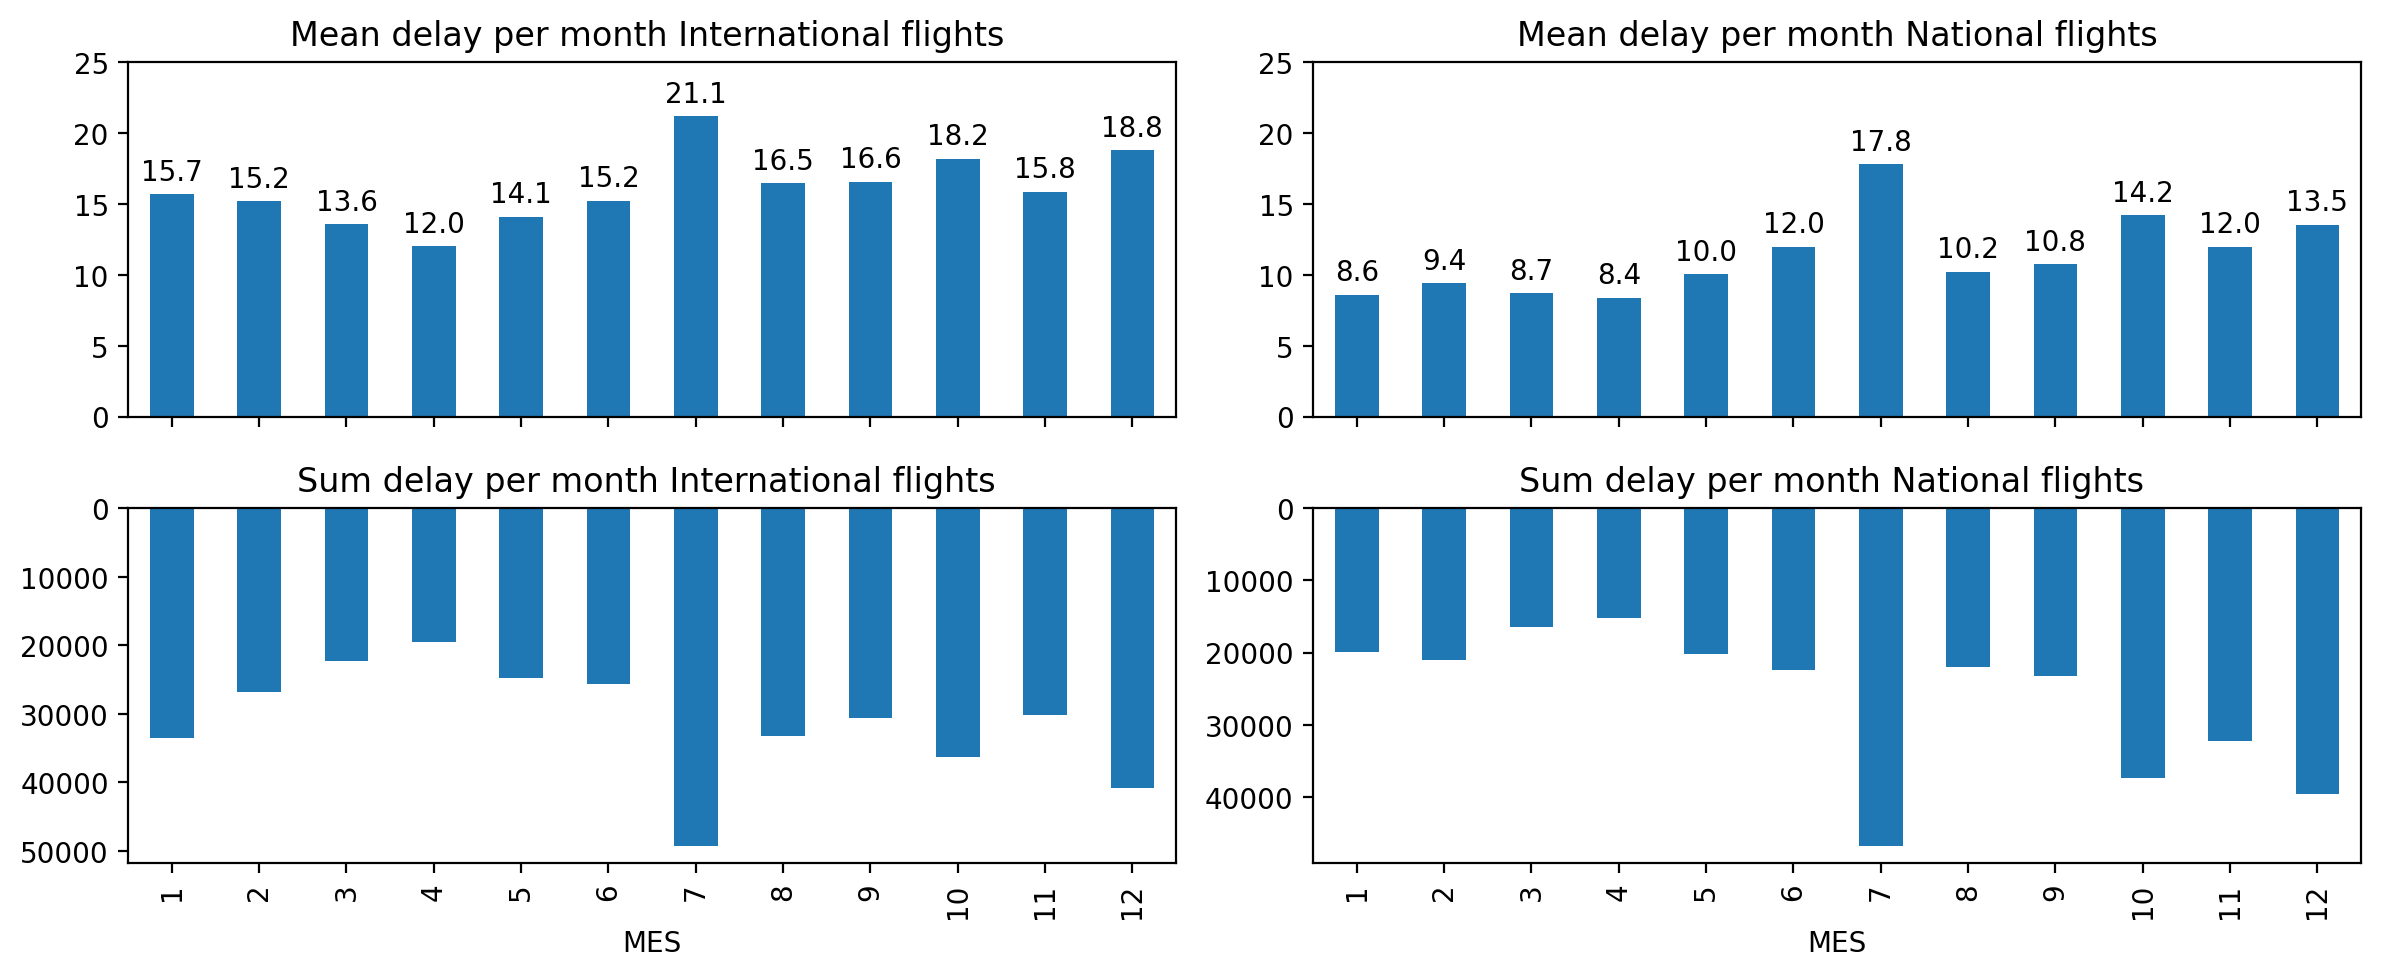

In [91]:
fig,axes = plt.subplots(2,2,figsize=(15,5),sharex=True)

df[df.min_diff.ge(0)][df.TIPOVUELO=='I'].groupby('MES')['min_diff'].mean().plot.bar(figsize=(12,5),ax=axes[0,0])
df[df.min_diff.ge(0)][df.TIPOVUELO=='I'].groupby('MES')['min_diff'].sum().plot.bar(figsize=(12,5),ax=axes[1,0])

df[df.min_diff.ge(0)][df.TIPOVUELO=='N'].groupby('MES')['min_diff'].mean().plot.bar(figsize=(12,5),ax=axes[0,1])
df[df.min_diff.ge(0)][df.TIPOVUELO=='N'].groupby('MES')['min_diff'].sum().plot.bar(figsize=(12,5),ax=axes[1,1])

axes[0,0].bar_label(axes[0,0].containers[0], fmt='%1.1f', padding=3)
axes[0,1].bar_label(axes[0,1].containers[0], fmt='%1.1f', padding=3)

axes[0,1].set_title('Mean delay per month National flights')
axes[1,0].set_title('Sum delay per month International flights ')
axes[0,0].set_title('Mean delay per month International flights ')
axes[1,1].set_title('Sum delay per month National flights ')

axes[1,0].invert_yaxis()
axes[1,1].invert_yaxis()
axes[0,0].set_ylim(0, 25)
axes[0,1].set_ylim(0, 25)
fig.tight_layout();

<Axes: xlabel='MES'>

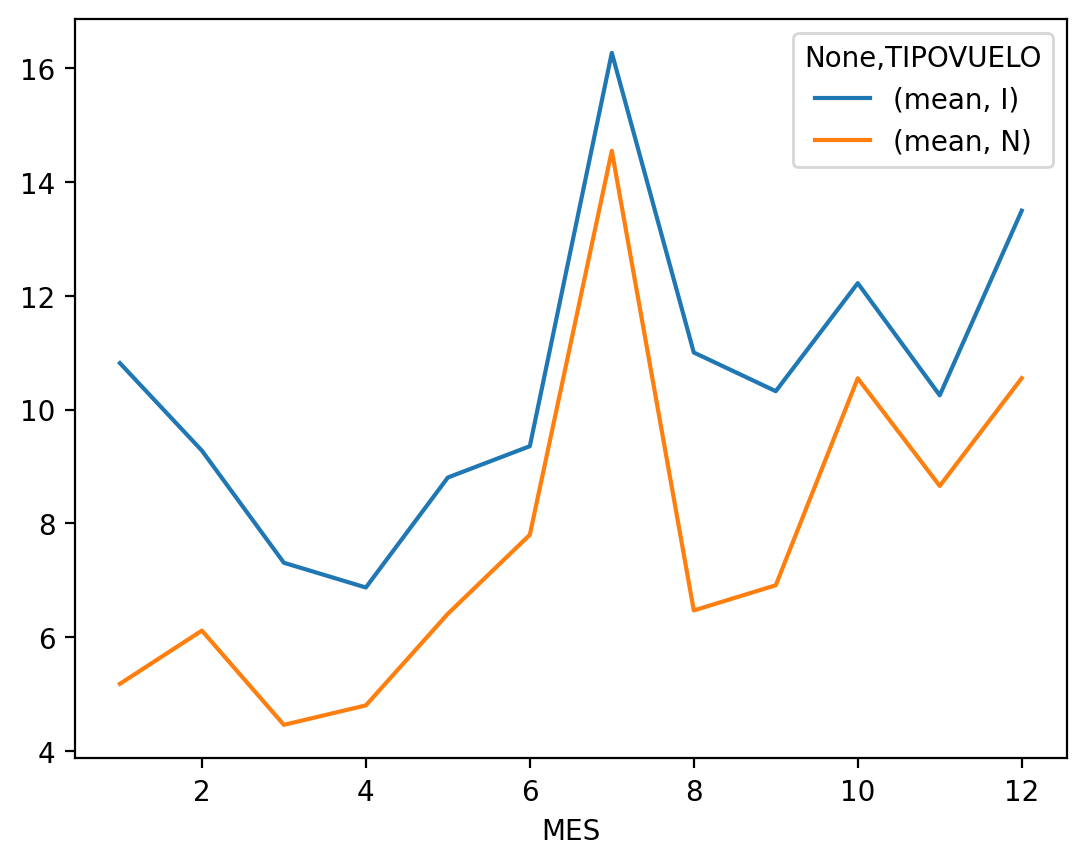

In [97]:
df.groupby(['TIPOVUELO','MES'])['min_diff'].agg(["mean"]).unstack(level=0).plot()

### 4. Train one or several models (using the algorithm(s) of your choice) to estimate the likelihood of a flight delay. Feel free to generate additional variables and/or supplement with external variables.

In [105]:
Var_to_dummies = ['OPERA','SIGLAORI','SIGLADES','Emp-I','DIA','MES','TIPOVUELO','high_season','period_day']
df = df.set_index('Fecha-I')


data leakege variables:
We only know that 
1. Emp-O : In theory we dont have this data before delay
2. 

In [113]:
df[~(df['Emp-I'] == df['Emp-O'])][['Emp-I','Emp-O','OPERA']]

Emp-I Emp-O                 OPERA
Fecha-I                                              
2017-01-21 22:30:00   AUT   ARG               Austral
2017-01-01 07:14:00   AVA   LRC               Avianca
2017-01-02 07:00:00   AVA   LRC               Avianca
2017-01-03 07:14:00   AVA   LRC               Avianca
2017-01-04 07:00:00   AVA   LRC               Avianca
...                   ...   ...                   ...
2017-12-26 16:30:00   LAW   JMR  Latin American Wings
2017-12-27 16:30:00   LAW   JMR  Latin American Wings
2017-12-28 16:30:00   LAW   JMR  Latin American Wings
2017-12-29 16:30:00   LAW   JMR  Latin American Wings
2017-12-31 17:30:00   LAW   JMR  Latin American Wings

[18669 rows x 3 columns]

In [109]:
df[['Emp-I','Emp-O','OPERA']]

Emp-I Emp-O              OPERA
Fecha-I                                           
2017-01-01 23:30:00   AAL   AAL  American Airlines
2017-01-02 23:30:00   AAL   AAL  American Airlines
2017-01-03 23:30:00   AAL   AAL  American Airlines
2017-01-04 23:30:00   AAL   AAL  American Airlines
2017-01-05 23:30:00   AAL   AAL  American Airlines
...                   ...   ...                ...
2017-12-22 14:55:00   JAT   JAT       JetSmart SPA
2017-12-25 14:55:00   JAT   JAT       JetSmart SPA
2017-12-27 14:55:00   JAT   JAT       JetSmart SPA
2017-12-29 14:55:00   JAT   JAT       JetSmart SPA
2017-12-31 14:55:00   JAT   JAT       JetSmart SPA

[68206 rows x 3 columns]

In [107]:
df

Vlo-I Ori-I Des-I Emp-I             Fecha-O  Vlo-O Ori-O  \
Fecha-I                                                                        
2017-01-01 23:30:00   226  SCEL  KMIA   AAL 2017-01-01 23:33:00    226  SCEL   
2017-01-02 23:30:00   226  SCEL  KMIA   AAL 2017-01-02 23:39:00    226  SCEL   
2017-01-03 23:30:00   226  SCEL  KMIA   AAL 2017-01-03 23:39:00    226  SCEL   
2017-01-04 23:30:00   226  SCEL  KMIA   AAL 2017-01-04 23:33:00    226  SCEL   
2017-01-05 23:30:00   226  SCEL  KMIA   AAL 2017-01-05 23:28:00    226  SCEL   
...                   ...   ...   ...   ...                 ...    ...   ...   
2017-12-22 14:55:00   400  SCEL  SPJC   JAT 2017-12-22 15:41:00  400.0  SCEL   
2017-12-25 14:55:00   400  SCEL  SPJC   JAT 2017-12-25 15:11:00  400.0  SCEL   
2017-12-27 14:55:00   400  SCEL  SPJC   JAT 2017-12-27 15:35:00  400.0  SCEL   
2017-12-29 14:55:00   400  SCEL  SPJC   JAT 2017-12-29 15:08:00  400.0  SCEL   
2017-12-31 14:55:00   400  SCEL  SPJC   JAT 2017-12-31 15:04:00  400.0  SCEL   

                    Des-O Emp-O  DIA  MES   AÑO     DIANOM TIPOVUELO  \
Fecha-I                                                                
2017-01-01 23:30:00  KMIA   AAL    1    1  2017    Domingo         I   
2017-01-02 23:30:00  KMIA   AAL    2    1  2017      Lunes         I   
2017-01-03 23:30:00  KMIA   AAL    3    1  2017     Martes         I   
2017-01-04 23:30:00  KMIA   AAL    4    1  2017  Miercoles         I   
2017-01-05 23:30:00  KMIA   AAL    5    1  2017     Jueves         I   
...                   ...   ...  ...  ...   ...        ...       ...   
2017-12-22 14:55:00  SPJC   JAT   22   12  2017    Viernes         I   
2017-12-25 14:55:00  SPJC   JAT   25   12  2017      Lunes         I   
2017-12-27 14:55:00  SPJC   JAT   27   12  2017  Miercoles         I   
2017-12-29 14:55:00  SPJC   JAT   29   12  2017    Viernes         I   
2017-12-31 14:55:00  SPJC   JAT   31   12  2017    Domingo         I   

                                 OPERA  SIGLAORI SIGLADES  high_season  \
Fecha-I                                                                  
2017-01-01 23:30:00  American Airlines  Santiago    Miami          1.0   
2017-01-02 23:30:00  American Airlines  Santiago    Miami          1.0   
2017-01-03 23:30:00  American Airlines  Santiago    Miami          1.0   
2017-01-04 23:30:00  American Airlines  Santiago    Miami          1.0   
2017-01-05 23:30:00  American Airlines  Santiago    Miami          1.0   
...                                ...       ...      ...          ...   
2017-12-22 14:55:00       JetSmart SPA  Santiago     Lima          1.0   
2017-12-25 14:55:00       JetSmart SPA  Santiago     Lima          1.0   
2017-12-27 14:55:00       JetSmart SPA  Santiago     Lima          1.0   
2017-12-29 14:55:00       JetSmart SPA  Santiago     Lima          1.0   
2017-12-31 14:55:00       JetSmart SPA  Santiago     Lima          1.0   

                     min_diff  delay_15 period_day  
Fecha-I                                             
2017-01-01 23:30:00       3.0         0      night  
2017-01-02 23:30:00       9.0         0      night  
2017-01-03 23:30:00       9.0         0      night  
2017-01-04 23:30:00       3.0         0      night  
2017-01-05 23:30:00      -2.0         0      night  
...                       ...       ...        ...  
2017-12-22 14:55:00      46.0         1  afternoon  
2017-12-25 14:55:00      16.0         1  afternoon  
2017-12-27 14:55:00      40.0         1  afternoon  
2017-12-29 14:55:00      13.0         0  afternoon  
2017-12-31 14:55:00       9.0         0  afternoon  

[68206 rows x 21 columns]

In [103]:
pd.get_dummies(df[])

Aerolineas Argentinas  Aeromexico  Air Canada  Air France  Alitalia  \
0                          0           0           0           0         0   
1                          0           0           0           0         0   
2                          0           0           0           0         0   
3                          0           0           0           0         0   
4                          0           0           0           0         0   
...                      ...         ...         ...         ...       ...   
68201                      0           0           0           0         0   
68202                      0           0           0           0         0   
68203                      0           0           0           0         0   
68204                      0           0           0           0         0   
68205                      0           0           0           0         0   

       American Airlines  Austral  Avianca  British Airways  Copa Air  \
0                      1        0        0                0         0   
1                      1        0        0                0         0   
2                      1        0        0                0         0   
3                      1        0        0                0         0   
4                      1        0        0                0         0   
...                  ...      ...      ...              ...       ...   
68201                  0        0        0                0         0   
68202                  0        0        0                0         0   
68203                  0        0        0                0         0   
68204                  0        0        0                0         0   
68205                  0        0        0                0         0   

       Delta Air  Gol Trans  Grupo LATAM  Iberia  JetSmart SPA  K.L.M.  Lacsa  \
0              0          0            0       0             0       0      0   
1              0          0            0       0             0       0      0   
2              0          0            0       0             0       0      0   
3              0          0            0       0             0       0      0   
4              0          0            0       0             0       0      0   
...          ...        ...          ...     ...           ...     ...    ...   
68201          0          0            0       0             1       0      0   
68202          0          0            0       0             1       0      0   
68203          0          0            0       0             1       0      0   
68204          0          0            0       0             1       0      0   
68205          0          0            0       0             1       0      0   

       Latin American Wings  Oceanair Linhas Aereas  Plus Ultra Lineas Aereas  \
0                         0                       0                         0   
1                         0                       0                         0   
2                         0                       0                         0   
3                         0                       0                         0   
4                         0                       0                         0   
...                     ...                     ...                       ...   
68201                     0                       0                         0   
68202                     0                       0                         0   
68203                     0                       0                         0   
68204                     0                       0                         0   
68205                     0                       0                         0   

       Qantas Airways  Sky Airline  United Airlines  
0                   0            0                0  
1                   0            0                0  
2                   0            0                0  
3                   0          

## Anexos : Visualización

In [ ]:
For download 

In [446]:
# read the shapefile of Chile's cities
chile_comunas = gpd.read_file('comunas.shp')
chile_regional = gpd.read_file('Regional.shp')

In [460]:
indices_destino = df[df.TIPOVUELO=='N'].groupby(['SIGLADES'])['min_diff'].agg(["mean"]).sort_values(by='mean').index

In [548]:
loc_nationals = df[df.TIPOVUELO=='N'].SIGLADES.unique().tolist()
loc_internationals = df[df.TIPOVUELO=='I'].SIGLADES.unique().tolist()

In [551]:
national = df[df.TIPOVUELO=='N'].groupby(['SIGLADES'])['min_diff'].agg(["mean"],as_index=False).sort_values(by='mean')

In [560]:
loc_nationals = ['Puerto Natales', 'Calama', 'Castro (Chiloe)', 'Antofagasta', 'Arica',
       'Copiapo', 'Valdivia', 'La Serena', 'Temuco', 'Concepción, Chile', 'Iquique',
       'Puerto Montt', 'Balmaceda', 'Punta Arenas', 'Osorno, Chile',
       'Isla de Pascua']

In [567]:
list_region_from_city = get_location(loc_nationals)

In [570]:
loc_regions = pd.DataFrame(list_region_from_city)[0].apply(lambda x: x.split(' ',1)[1:][0]).tolist()

In [572]:
national["region"] = loc_regions
national.iloc[0,1] = "Región de Magallanes y Antártica Chilena"
national.loc['Concepcion','region'] = 'Región del Bío-Bío'
national.loc['Temuco','region'] = 'Región de La Araucanía'

In [576]:
df = df.merge(national.reset_index()[['SIGLADES','region']], left_on='SIGLADES', right_on='SIGLADES', how='left')

In [ ]:
national = df.groupby('region',as_index=False)['min_diff'].mean()
merge = chile_regional.merge( national, left_on='Region', right_on='region', how='left')

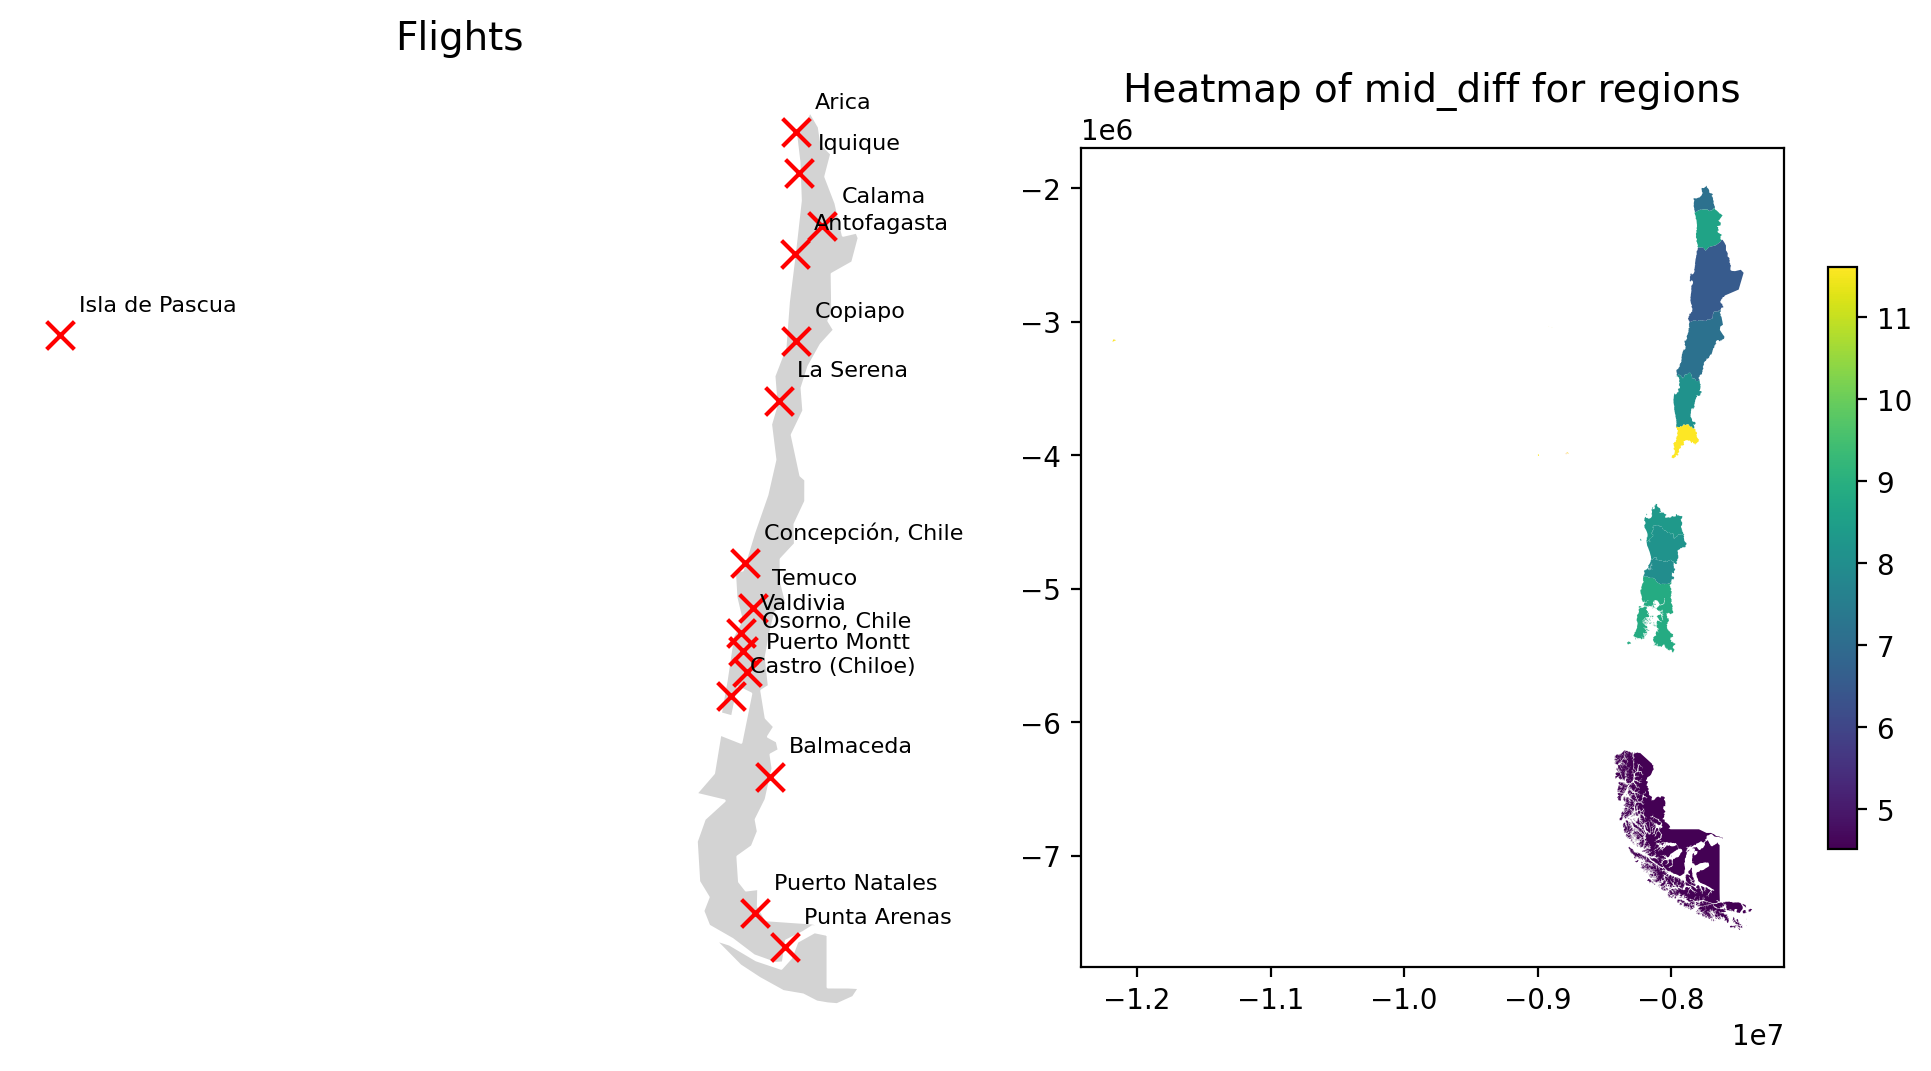

In [547]:
# Define the cities
cities = loc_nationals

# Geocode the cities to obtain their coordinates
geolocator = Nominatim(user_agent='my_app')
locations = [geolocator.geocode(city) for city in cities]
latitudes = [location.latitude for location in locations]
longitudes = [location.longitude for location in locations]

# Create a DataFrame with the city names and coordinates
data = {'City': cities, 'Latitude': latitudes, 'Longitude': longitudes}
df_ = pd.DataFrame(data)

# Read the world map dataset
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Select only Chile
chile = world[world.name == 'Chile']

# Plot the cities on the world map
fig, ax = plt.subplots(1,2,figsize=(10, 10))

merge.plot(column='min_diff', ax=ax[1], legend=True, legend_kwds={'shrink': 0.3})
ax[1].set_title('Heatmap of mid_diff for regions', fontsize=14)

chile.plot(ax=ax[0], color='lightgray', edgecolor='white')
ax[0].scatter(df_['Longitude'], df_['Latitude'], color='red', marker='x', s=100)
for i, row in df_.iterrows():
    ax[0].text(row['Longitude'] + 1, row['Latitude'] + 1, row['City'], fontsize=8)
ax[0].set_title('Flights', fontsize=14)
ax[0].set_axis_off()
fig.tight_layout()
plt.show()


In [671]:
df.loc[df.min_diff<=0,'delay_label'] = 0
df.loc[df.min_diff>0,'delay_label'] = 1

In [672]:
from scipy.stats import chi2_contingency
from sklearn.preprocessing import OneHotEncoder

In [687]:
df_object = df.select_dtypes(include='object').drop(columns = ['region_x','region_y']).astype(str)

In [693]:
# Create a OneHotEncoder object
encoder = OneHotEncoder()

# Fit the encoder to the DataFrame
encoder.fit(df_object)

# Transform the DataFrame using the encoder
one_hot_encoded = encoder.transform(df_object).toarray()
feature_names = encoder.get_feature_names_out(df_object.columns)
# Create a new DataFrame with the one hot encoded data
one_hot_df = pd.DataFrame(one_hot_encoded, columns=feature_names)


## Exploratory Data Analysis

- Fecha-I: Scheduled date and time of the flight.
- Vlo-I : Scheduled flight number.
- Ori-I : Programmed origin city code.
- Des-I : Programmed destination city code.
- Emp-I : Scheduled flight airline code.
- Fecha-O : Date and time of flight operation.
- Vlo-O : Flight operation number of the flight.
- Ori-O : Operation origin city code
- Des-O : Operation destination city code.
- Emp-O : Airline code of the operated flight.
- DIA: Day of the month of flight operation.
- MES : Number of the month of operation of the flight.
- AÑO : Year of flight operation.
- DIANOM : Day of the week of flight operation.
- TIPOVUELO : Type of flight, I =International, N =National.
- OPERA : Name of the airline that operates.
- SIGLAORI: Name city of origin.
- SIGLADES: Destination city name.